# **III. Machine Learning**

## **1. Data Preprocessing**

### Add Buckets

In [ ]:
# Redefine the DPD bucket classification function, as the environment has reset
def classify_dpd_bucket(days_overdue):
    if days_overdue == 0:
        return "B0"
    elif 1 <= days_overdue <= 9:
        return "B1"
    elif 10 <= days_overdue <= 30:
        return "B2"
    elif 31 <= days_overdue <= 60:
        return "B3"
    elif 61 <= days_overdue <= 90:
        return "B4"
    elif 91 <= days_overdue <= 120:
        return "B5"
    elif 121 <= days_overdue <= 150:
        return "B6"
    elif 151 <= days_overdue <= 180:
        return "B7"
    elif 181 <= days_overdue <= 210:
        return "B8"
    elif 211 <= days_overdue <= 240:
        return "B9"
    elif 241 <= days_overdue <= 270:
        return "B10"
    elif 271 <= days_overdue <= 300:
        return "B11"
    elif 301 <= days_overdue <= 330:
        return "B12"
    elif 331 <= days_overdue <= 360:
        return "B13"
    else:
        return "B14"
# Apply the DPD bucket classification function to the new data
df_repayment['DPD_BUCKET'] = df_repayment['OVER_DUE_DAYS_LD'].apply(classify_dpd_bucket)


### Filter B0 and MONTH_ON_BOOK >= 3

In [ ]:
# Filter rows where DPD_BUCKET is "B0" and MONTH_ON_BOOK equals 3
filtered_b0_month3 = df_repayment[(df_repayment['DPD_BUCKET'] == "B0") & (df_repayment['MONTH_ON_BOOK'] == 3)]

# Include all rows where MONTH_ON_BOOK is greater than 3
filtered_after_month3 = df_repayment[df_repayment['MONTH_ON_BOOK'] > 3]

# Take out CONTRACT_NO in filtered_b0_month3
valid_contracts = filtered_b0_month3['CONTRACT_NO'].unique()

# Keep rows only where filtered_after_month3 have CONTRACT_NO in valid_contracts
filtered_after_month3 = filtered_after_month3[filtered_after_month3['CONTRACT_NO'].isin(valid_contracts)]

# Combine the filtered dataframes
filtered_df = pd.concat([filtered_b0_month3, filtered_after_month3])


### Add target variable "IS_ROLL_UP"

In [ ]:
# Sort data by CONTRACT_NO and SYS_RUN_DATE to process next month's DPD_BUCKET
filtered_df = filtered_df.sort_values(by=['CONTRACT_NO', 'SYS_RUN_DATE'])

# Shift DPD_BUCKET to get next month's bucket for each contract
filtered_df['NEXT_MONTH_DPD'] = filtered_df.groupby('CONTRACT_NO')['DPD_BUCKET'].shift(-1)

# Define the target variable: 1 if NEXT_MONTH_DPD is higher, 0 otherwise, NaN if no next month
def create_target_variable(current, next_month):
    if pd.isna(next_month):  # Nếu không có thông tin của tháng sau
        return None  # Trả về NaN
    if next_month > current:
        return 1  # Rolled into a higher bucket
    return 0  # Did not roll into a higher bucket

# Apply the function to create the target variable
filtered_df['IS_ROLL_UP'] = filtered_df.apply(
    lambda row: create_target_variable(row['DPD_BUCKET'], row['NEXT_MONTH_DPD']), axis=1
)


### Fill Null

In [ ]:
# Fill null ở cột TOTAL_EMI_AMOUNT (tất cả các bản ghi có cùng contract_no thì đều có cùng TOTAL_EMI_AMOUNT )
filtered_df['TOTAL_EMI_AMOUNT'] = filtered_df.groupby('CONTRACT_NO')['TOTAL_EMI_AMOUNT'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# Các cột sau cũng fill bằng 0
filtered_df['TOTAL_OVERDUE_PERIOD'] = filtered_df['TOTAL_OVERDUE_PERIOD'].fillna(0)
filtered_df['MAX_DPD_HISTORY'] = filtered_df['MAX_DPD_HISTORY'].fillna(0)
filtered_df['LAST_PAYMENT_AMOUNT'] = filtered_df['LAST_PAYMENT_AMOUNT'].fillna(0)

<ipython-input-11-8ef3a3edbb48>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_df['TOTAL_EMI_AMOUNT'] = filtered_df.groupby('CONTRACT_NO')['TOTAL_EMI_AMOUNT'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


### Merge table

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1030020 entries, 50716 to 1274935
Data columns (total 20 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   CONTRACT_NO               1030020 non-null  int64  
 1   SYS_RUN_DATE              1030020 non-null  object 
 2   TOTAL_EMI_AMOUNT          1030020 non-null  float64
 3   DUE_DATE_OF_MON           977250 non-null   object 
 4   PARTNER_CODE              1030020 non-null  int64  
 5   OUTSTANDING               1030020 non-null  float64
 6   PRI_PAST_DUE              1030020 non-null  float64
 7   INT_PAST_DUE              1030020 non-null  float64
 8   OD_PAST_DUE               1030020 non-null  float64
 9   OVER_DUE_DAYS_LD          1030020 non-null  float64
 10  OVER_DUE_DAYS_CLIENT      1030020 non-null  float64
 11  LAST_PAYMENT_DATE         1030020 non-null  object 
 12  LAST_PAYMENT_AMOUNT       1030020 non-null  float64
 13  TOTAL_OVERDUE_PERIOD      10

In [ ]:
df = pd.merge(filtered_df, df_demo_loan, on='CONTRACT_NO', how='left')


In [ ]:
# Drop rows where LABOUR_CONTRACT_TYPE is null
df_nonull = df.dropna(subset=['LABOUR_CONTRACT_TYPE'])

In [ ]:
df = df_nonull.copy()

### Feature Engineering (doing)

#### Calculate Age

In [ ]:
df['Age'] = 2024 - df_nonull['DATE_OF_BIRTH']

#### Extract number from DPD Bucket


In [ ]:
# Tạo một cột mới chỉ chứa phần số từ cột DPD_BUCKET
df['BUCKET_NUMBER'] = df['DPD_BUCKET'].str.extract('(\d+)', expand=False).astype(int)

#### Calculate Weekday, Lunar day, 1-3 day of lunar day of Due date and Payment Date

In [ ]:
!pip install lunarcalendar

import pandas as pd
from lunarcalendar import Converter, Solar, Lunar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.6 MB/s eta 0:00:00


In [ ]:
df['SYS_RUN_DATE'] = pd.to_datetime(df['SYS_RUN_DATE'])
df['DUE_DATE_OF_MON'] = pd.to_datetime(df['DUE_DATE_OF_MON'], errors='coerce')
nearest_day = df['DUE_DATE_OF_MON'].dropna().dt.day.min()

# Điền giá trị null của DUE_DATE_OF_MON bằng ngày gần nhất của tháng và năm từ SYS_RUN_DATE
df['DUE_DATE_OF_MON'] = df['DUE_DATE_OF_MON'].fillna(
    df['SYS_RUN_DATE'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=nearest_day)if pd.notnull(x) else pd.NaT))

df['DUE_DATE_OF_MON'] = pd.to_datetime(df['DUE_DATE_OF_MON'], errors='coerce')
df['LAST_PAYMENT_DATE'] = pd.to_datetime(df['LAST_PAYMENT_DATE'], errors='coerce')

# Add weekday column (Monday = 1, Sunday = 7)
df['WEEKDAY_DUE_DATE'] = df['DUE_DATE_OF_MON'].dt.weekday + 1
df['WEEKDAY_PAYMENT_DATE'] = df['LAST_PAYMENT_DATE'].dt.weekday + 1

# Function to convert Gregorian date to Lunar date
def convert_to_lunar(date):
    try:
        solar = Solar(date.year, date.month, date.day)  # Create a Solar object
        lunar = Converter.Solar2Lunar(solar)  # Convert Solar to Lunar
        return f"{lunar.year}-{lunar.month}-{lunar.day}"  # Return formatted Lunar date
    except:
        return None  # Return None for invalid dates

# Add Lunar Date column
df['LUNAR_DATE_DUE_DATE'] = df['DUE_DATE_OF_MON'].apply(convert_to_lunar)
df['LUNAR_DATE_PAYMENT_DATE'] = df['LAST_PAYMENT_DATE'].apply(convert_to_lunar)

# Adjust WEEKDAY for CONTRACT_NO groups (add 0 for the first row of each group)
def adjust_weekday(series):
    return [0] + list(series.iloc[1:].values)

df['WEEKDAY_DUE_DATE'] = df.groupby('CONTRACT_NO')['WEEKDAY_DUE_DATE'].transform(adjust_weekday)
df['WEEKDAY_PAYMENT_DATE'] = df.groupby('CONTRACT_NO')['WEEKDAY_PAYMENT_DATE'].transform(adjust_weekday)


In [ ]:
# Function to check if a Lunar Date falls on the 1st or 2nd or 3rd day of the lunar month
def is_lunar_1_or_2_or_3_day(lunar_date):
    try:
        if lunar_date:
            lunar_day = int(lunar_date.split('-')[2])  # Extract the day part of Lunar Date
            return lunar_day in [1, 2, 3]  # Check if it's the 1st or 2nd day
        return False
    except:
        return False

# Add a new column to indicate if DUE_DATE is Lunar 1st or 2nd
df['IS_LUNAR_1-3_DAY_DUE_DATE'] = df['LUNAR_DATE_DUE_DATE'].apply(is_lunar_1_or_2_or_3_day).astype(int)

# Add a new column to indicate if PAYMENT_DATE is Lunar 1st or 2nd
df['IS_LUNAR_1-3_DAY_PAYMENT_DATE'] = df['LUNAR_DATE_PAYMENT_DATE'].apply(is_lunar_1_or_2_or_3_day).astype(int)


In [ ]:
df[['IS_LUNAR_1-3_DAY_DUE_DATE', 'IS_LUNAR_1-3_DAY_PAYMENT_DATE', 'BUCKET_NUMBER']][(df['IS_LUNAR_1-3_DAY_DUE_DATE'] == 1) & (df['BUCKET_NUMBER'] == 1)]

# Đào sẽ ra INSIGHT khách hàng ko đi trả nợ vào đầu tháng dẫn đến việc lên mức nợ B1 => Đưa ra đề xuất làm cách nào đấy để xử lý

,IS_LUNAR_1-3_DAY_DUE_DATE,IS_LUNAR_1-3_DAY_PAYMENT_DATE,BUCKET_NUMBER
33339,1,0,1
39238,1,0,1
40008,1,0,1
41668,1,0,1
42958,1,0,1
...,...,...,...
1029272,1,0,1
1029292,1,0,1
1029421,1,0,1
1029431,1,0,1


#### Data after feature engineering

In [ ]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,1030010,1030011,1030012,1030013,1030014,1030015,1030016,1030017,1030018,1030019
CONTRACT_NO,340732,340732,340732,340732,340732,340732,340732,340732,340732,340732,...,856747,856747,856747,856747,856747,856747,856747,856747,856747,856747
SYS_RUN_DATE,2022-06-01 00:00:00,2022-07-01 00:00:00,2022-08-01 00:00:00,2022-09-01 00:00:00,2022-10-01 00:00:00,2022-11-01 00:00:00,2022-12-01 00:00:00,2023-01-01 00:00:00,2023-02-01 00:00:00,2023-03-01 00:00:00,...,2023-05-01 00:00:00,2023-06-01 00:00:00,2023-07-01 00:00:00,2023-08-01 00:00:00,2023-09-01 00:00:00,2023-10-01 00:00:00,2023-11-01 00:00:00,2023-12-01 00:00:00,2024-01-01 00:00:00,2024-02-01 00:00:00
TOTAL_EMI_AMOUNT,828.049918,828.049918,828.049918,828.049918,828.049918,828.049918,828.049918,828.049918,828.049918,828.049918,...,631.664468,631.664468,631.664468,631.664468,631.664468,631.664468,631.664468,631.664468,631.664468,631.664468
DUE_DATE_OF_MON,2022-06-02 00:00:00,2022-07-02 00:00:00,2022-08-02 00:00:00,2022-09-03 00:00:00,2022-10-02 00:00:00,2022-11-02 00:00:00,2022-12-02 00:00:00,2023-01-03 00:00:00,2023-02-02 00:00:00,2023-03-02 00:00:00,...,2023-05-18 00:00:00,2023-06-19 00:00:00,2023-07-18 00:00:00,2023-08-18 00:00:00,2023-09-02 00:00:00,2023-10-02 00:00:00,2023-11-02 00:00:00,2023-12-02 00:00:00,2024-01-02 00:00:00,2024-02-02 00:00:00
PARTNER_CODE,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
OUTSTANDING,3413.815021,3374.102794,3334.500162,3296.924072,3247.585359,3201.645983,3151.407199,3104.193508,3046.929055,2984.721986,...,1088.19407,1087.658034,1087.658034,1087.658034,1087.658034,1087.658034,1087.658034,1087.504789,1087.504789,1087.504789
PRI_PAST_DUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,627.340418,887.8504,1087.658034,1087.658034,1087.658034,1087.658034,1087.504789,1087.504789,1087.504789
INT_PAST_DUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OD_PAST_DUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OVER_DUE_DAYS_LD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,43.0,74.0,104.0,135.0,165.0,196.0,227.0,256.0


In [ ]:
df.columns

Index(['CONTRACT_NO', 'SYS_RUN_DATE', 'TOTAL_EMI_AMOUNT', 'DUE_DATE_OF_MON',
       'PARTNER_CODE', 'OUTSTANDING', 'PRI_PAST_DUE', 'INT_PAST_DUE',
       'OD_PAST_DUE', 'OVER_DUE_DAYS_LD', 'OVER_DUE_DAYS_CLIENT',
       'LAST_PAYMENT_DATE', 'LAST_PAYMENT_AMOUNT', 'TOTAL_OVERDUE_PERIOD',
       'MAX_DPD_HISTORY', 'MONTH_ON_BOOK', 'CUSTOMER_MAX_DPD_HISTORY',
       'DPD_BUCKET', 'NEXT_MONTH_DPD', 'IS_ROLL_UP', 'LABOUR_CONTRACT_TYPE',
       'NUMBER_OF_DEPENDANTS', 'PERMANENT_ADDRESS_PROVINCE', 'INDUSTRY', 'JOB',
       'COMPANY_ADDRESS_PROVINCE', 'WEIGHT', 'EDUCATION', 'CUSTOMER_INCOME',
       'CREDITIBILITY', 'ACCOMMODATION_TYPE', 'DATE_OF_BIRTH', 'HEIGHT',
       'WORKING_IN_YEAR', 'MARITAL_STATUS', 'INCOME_RESOURCE',
       'DISBURSEMENT_CHANNEL', 'LIQUIDITY', 'INSURANCE_COMPANY',
       'INSURANCE_RATE', 'RATE', 'HAS_INSURANCE', 'PRODUCT_CATEGORY',
       'LOAN_TERM', 'MONTH_INTEREST', 'LOAN_PURPOSE', 'BUSINESS_LINE',
       'LOAN_AMOUNT', 'month', 'year', 'Age', 'BUCKET_NUMBER',
  

### Correlation và Feature Importance


<ipython-input-25-dc3befbfe30c>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_with_target_df, x='Correlation', y='Feature', palette='coolwarm')


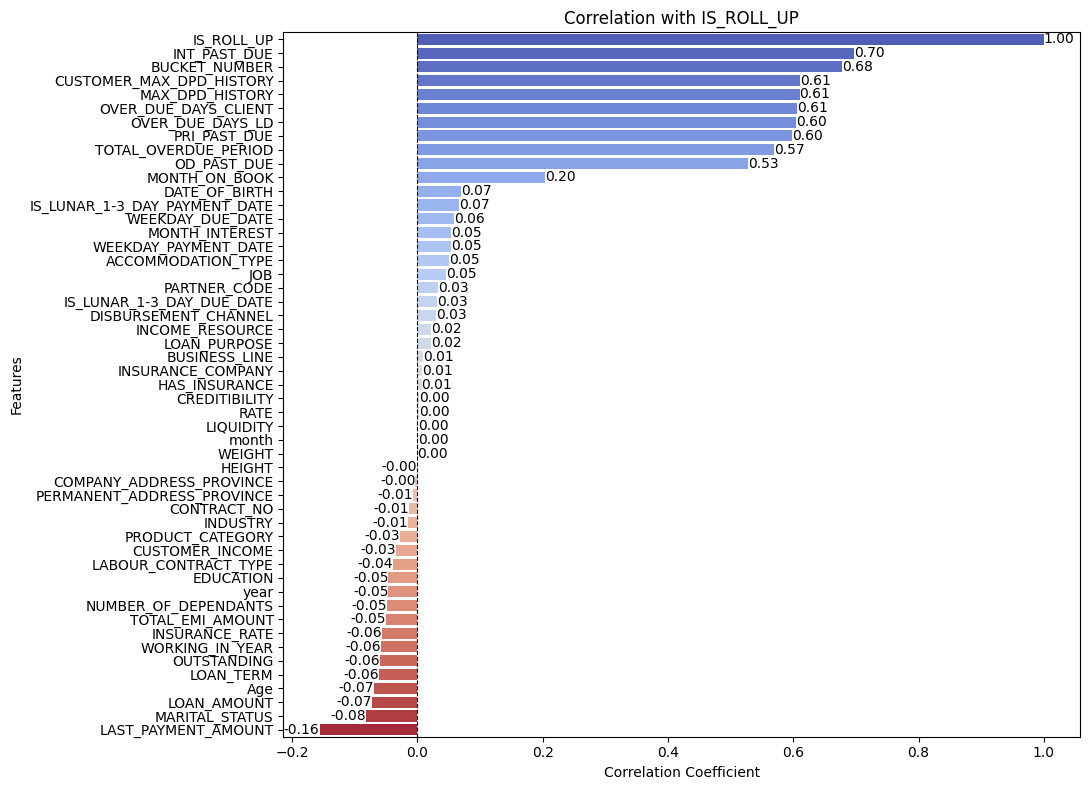

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns
numeric_columns = df.select_dtypes(include=np.number)

# Calculate correlation with 'IS_ROLL_UP'
corr_with_target = numeric_columns.corr(method='pearson')['IS_ROLL_UP'].sort_values(ascending=False)

# Convert correlation series to DataFrame for better visualization
corr_with_target_df = corr_with_target.reset_index()
corr_with_target_df.columns = ['Feature', 'Correlation']

# Plot the correlation as a bar chart
plt.figure(figsize=(11, 8))
sns.barplot(data=corr_with_target_df, x='Correlation', y='Feature', palette='coolwarm')

# Annotate the bars with the correlation values rounded to 2 decimal places
for index, row in corr_with_target_df.iterrows():
    plt.text(
        row['Correlation'],  # X-coordinate (correlation value)
        index,  # Y-coordinate (position of the bar)
        f"{row['Correlation']:.2f}",  # Format to 2 decimal places
        color='black',  # Text color
        ha='left' if row['Correlation'] >= 0 else 'right',  # Align text based on positive/negative value
        va='center'  # Align text vertically
    )

plt.title('Correlation with IS_ROLL_UP')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)  # Add a reference line at 0
plt.tight_layout()
plt.show()


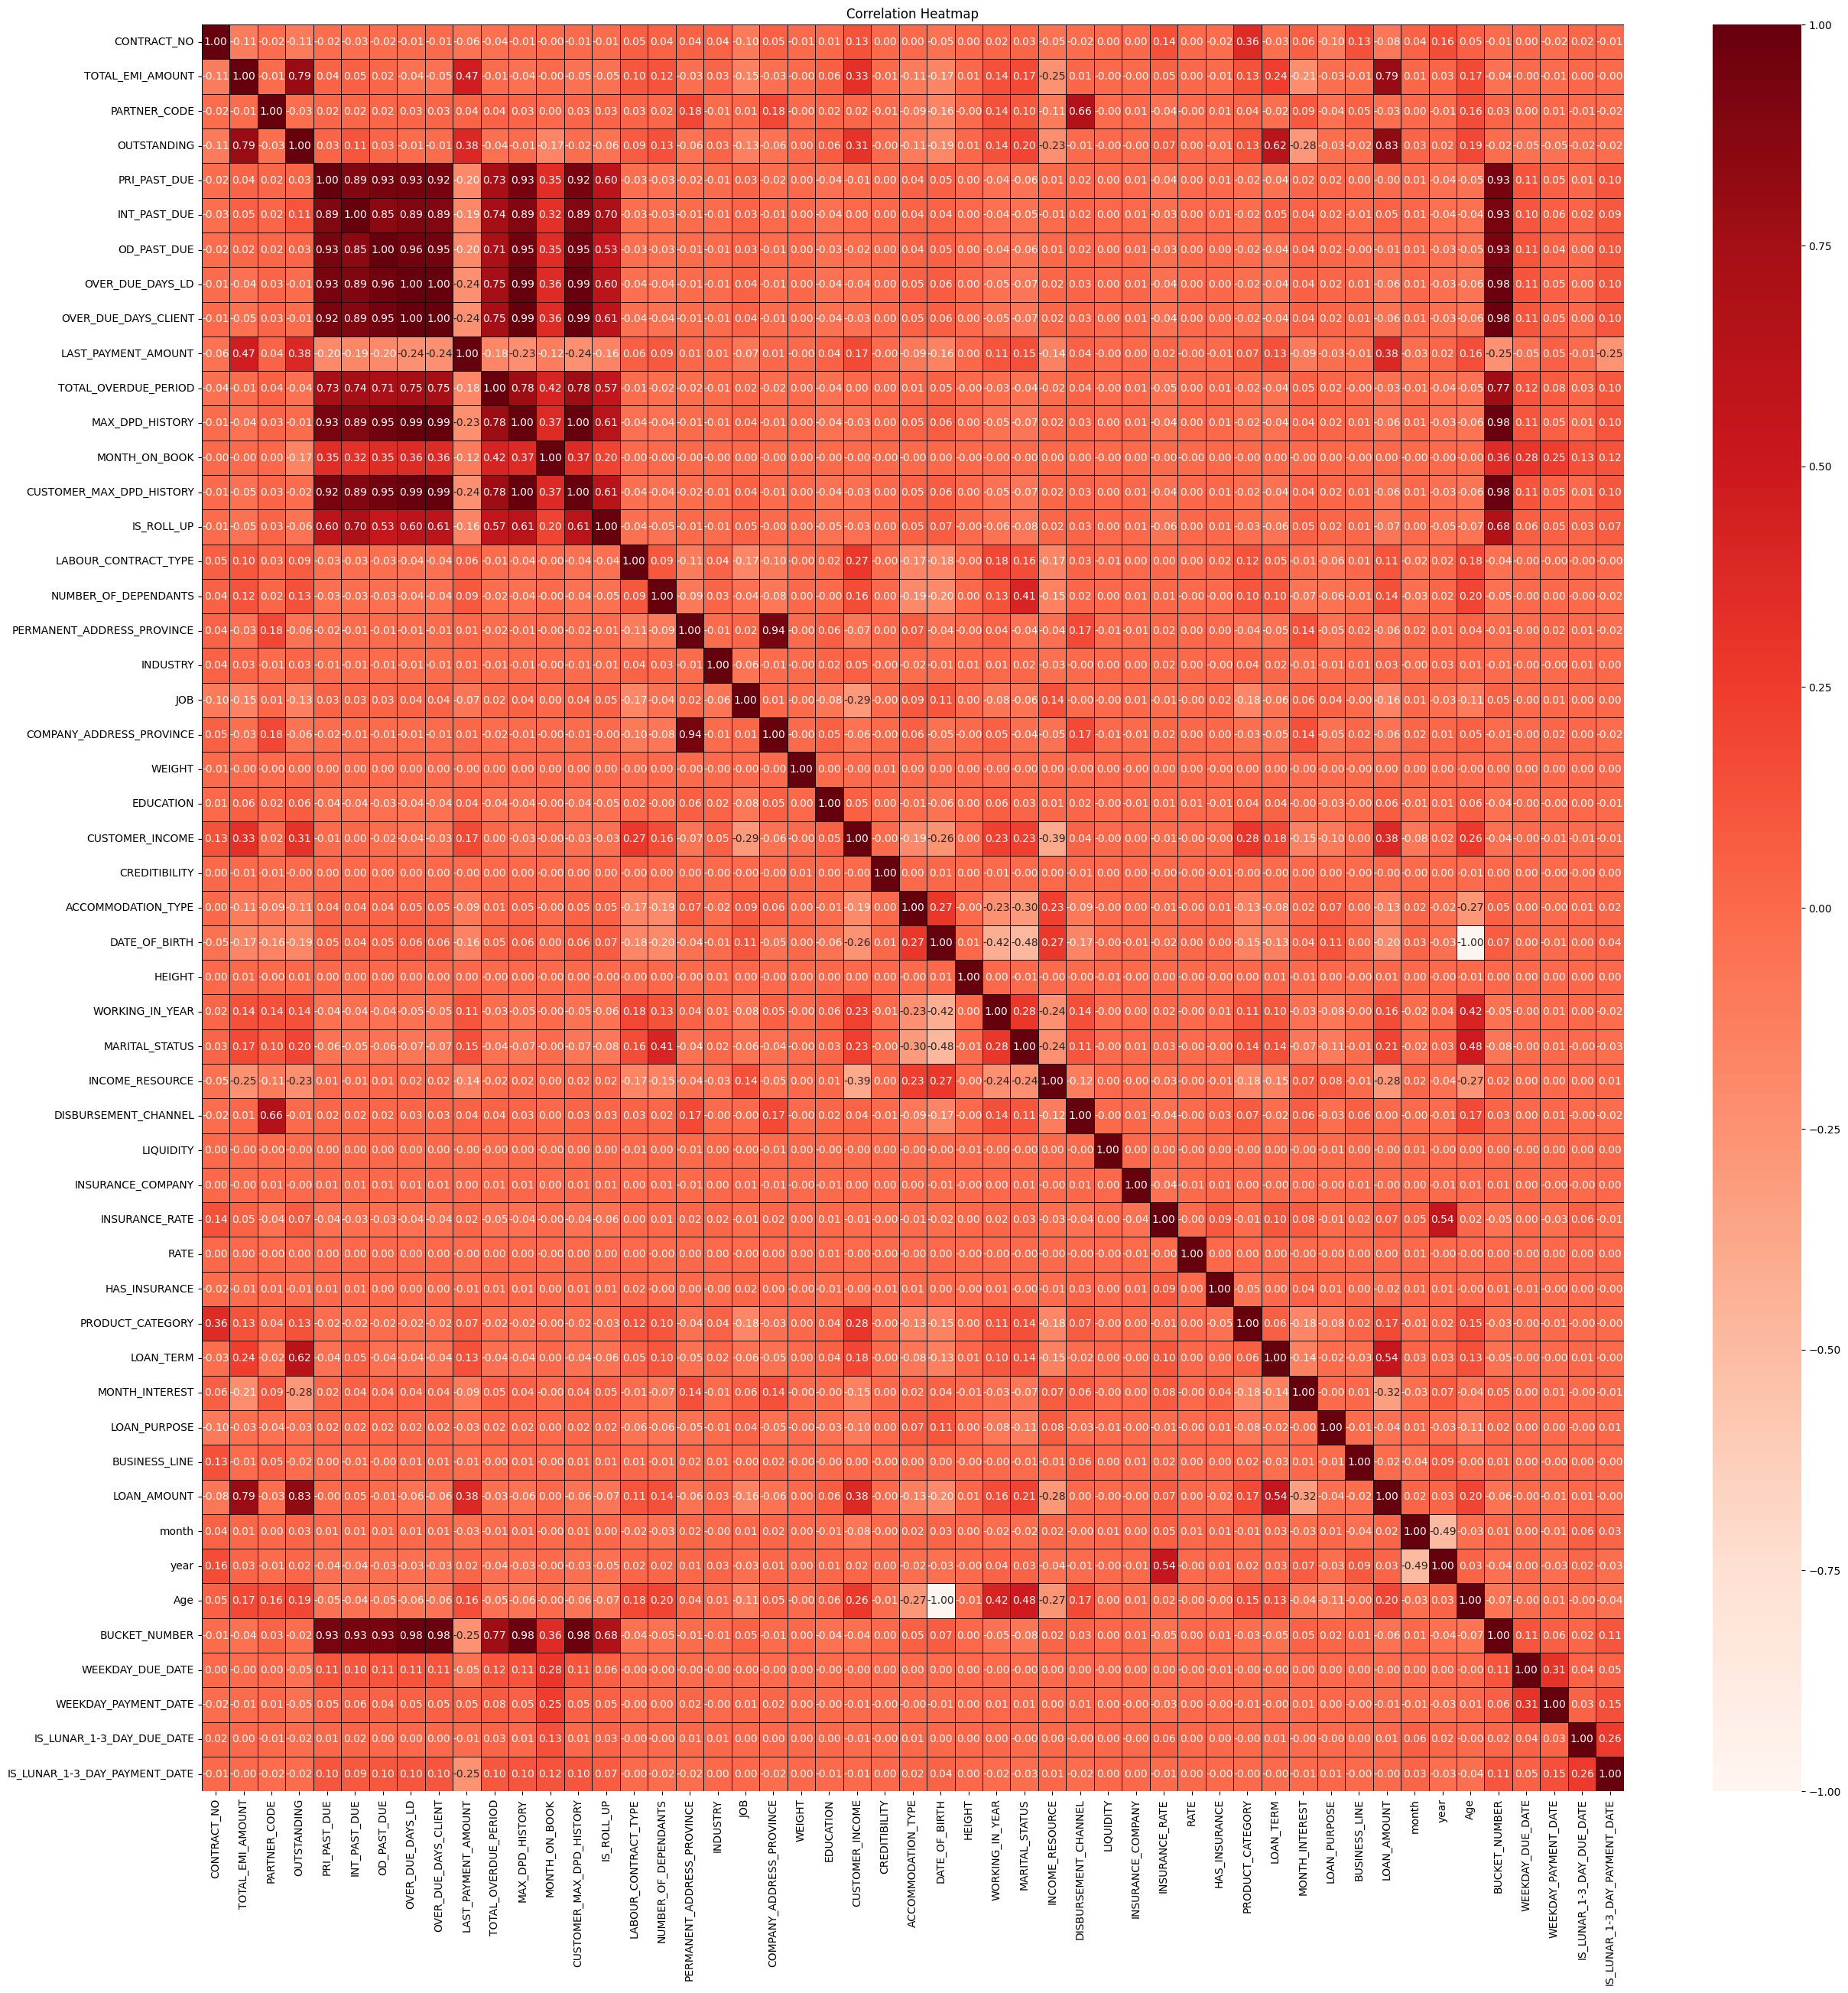

In [ ]:
# Calculate correlation matrix
# Select only numeric columns for correlation
corr_matrix = df.select_dtypes(include=np.number).corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True,cmap='Reds', linecolor='black',fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

### Feature Selection

#### Selecting features

In [ ]:
df_selection = df[[
    # Target variable
    'IS_ROLL_UP',

    # Demographic
    'MARITAL_STATUS',  # -0.08
    'Age',             # 0.20
    'NUMBER_OF_DEPENDANTS',  # -0.05
    'CUSTOMER_INCOME',       # -0.03
    'WORKING_IN_YEAR',

    # Loan Information
    'LOAN_AMOUNT',     # -0.07
    'LOAN_TERM',       # -0.06
    'MONTH_INTEREST',  # 0.05
    'PRODUCT_CATEGORY',    # -0.03
    'LOAN_PURPOSE',


    # Loan Repayment
    'MONTH_ON_BOOK',   # 0.53
    'TOTAL_EMI_AMOUNT',      # -0.05
    # 'PARTNER_CODE',        # 0.03
    'OUTSTANDING',           # -0.06
    'PRI_PAST_DUE',          # 0.60
    'INT_PAST_DUE',          # 0.70
    'OD_PAST_DUE',           # 0.60
    'OVER_DUE_DAYS_LD',      # 0.60
    # 'OVER_DUE_DAYS_CLIENT',  # 0.61 Không chọn vì mục tiêu liên quan đến hợp đồng hơn
    'LAST_PAYMENT_AMOUNT',   # -0.16
    'TOTAL_OVERDUE_PERIOD',  # 0.57
    'MAX_DPD_HISTORY',       # 0.61
    # 'CUSTOMER_MAX_DPD_HISTORY',  # 0.61

    # Behavior
    # 'WEEKDAY_DUE_DATE',      # 0.06
    'WEEKDAY_PAYMENT_DATE',  # 0.05
    'IS_LUNAR_1-3_DAY_DUE_DATE',  # 0.0
    'IS_LUNAR_1-3_DAY_PAYMENT_DATE'
]]



#### Evaluate selected

In [ ]:
# # kiểm tra và loại bỏ đa cộng tuyến (chứa thông tin như nhau)

# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # Kiểm tra đa cộng tuyến

# X_selected = df_selection.dropna()

# vif_data = pd.DataFrame()
# vif_data["Feature"] = X_selected.columns
# vif_data["VIF"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]

# print(vif_data)


### Split data into predict and model data

In [ ]:
# Tách các dòng có IS_ROLL_UP là NaN (dòng cần dự đoán)
df_to_predict = df_selection[df_selection['IS_ROLL_UP'].isna()]

# Tách các dòng có IS_ROLL_UP không phải NaN (dòng để huấn luyện mô hình)
df_to_model = df_selection[df_selection['IS_ROLL_UP'].notna()]

# Kiểm tra kết quả
print("Rows in df_to_predict:", len(df_to_predict))
print("Rows in df_to_model:", len(df_to_model))


Rows in df_to_predict: 87458
Rows in df_to_model: 787122


### Split data: train, test, predict

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_to_model.drop(columns=['IS_ROLL_UP'], axis=1)
y = df_to_model['IS_ROLL_UP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_predict = df_to_predict.drop(columns=['IS_ROLL_UP'], axis=1)

### Address Imbalance in IS_ROLL_UP USING OVERSAMPLING

In [ ]:
y_train.value_counts()

,count
IS_ROLL_UP,
0.0,484859
1.0,144838


In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE for oversampling
smote = SMOTE()
X_SMOTE, y_SMOTE = smote.fit_resample(X_train, y_train)

# Check the distribution of the target variable after oversampling
unique, counts = np.unique(y_SMOTE, return_counts=True)
print(dict(zip(unique, counts)))

# Combine the resampled features and target into a new DataFrame
df_SMOTE = pd.concat([pd.DataFrame(X_SMOTE, columns=X.columns), pd.DataFrame(y_SMOTE, columns=['IS_ROLL_UP'])], axis=1)


{0.0: 484859, 1.0: 484859}


### Scale data

In [ ]:
from sklearn.preprocessing import StandardScaler

# 1. Khởi tạo scaler
scaler = StandardScaler()

# 2. Fit scaler trên dữ liệu train
scaler.fit(X_SMOTE)

# 3. Transform dữ liệu train và test
X_train_scaled = scaler.transform(X_SMOTE)
X_test_scaled = scaler.transform(X_test)

# 4. Transform dữ liệu predict (bạn không fit lại, chỉ transform)
X_predict_scaled = scaler.transform(X_predict)


## **2. Modeling**

#### Logistic Regression

##### Tunning hyperparameter

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# Khởi tạo Logistic Regression
log = LogisticRegression(random_state=42, max_iter=1000)

# Tập tham số cần tìm
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],              # Regularization types
    'solver': ['liblinear', 'saga'],      # Solvers phù hợp với penalty
}

# Random Search
random_search = RandomizedSearchCV(
    estimator=log,
    param_distributions=param_dist,
    n_iter=20,         # Số lần thử nghiệm
    scoring='roc_auc', # Đánh giá dựa trên AUC
    cv=5,              # 5-fold cross-validation
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# Fit trên tập train
random_search.fit(X_train_scaled, y_SMOTE)

# Lấy tham số tốt nhất
best_params = random_search.best_params_
print("Best Parameters: ", best_params)

# Mô hình tối ưu
best_model_log = random_search.best_estimator_


Best Parameters:  {'solver': 'saga', 'penalty': 'l1', 'C': 100}

##### Cross Validation + Evaluation

In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# Hàm tính GINI
def calculate_gini(y_true, y_proba):
    auc = roc_auc_score(y_true, y_proba)
    return 2 * auc - 1

# Hàm tính KS
def calculate_ks(y_true, y_proba):
    data = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    data = data.sort_values(by='y_proba', ascending=False)
    data['cum_good'] = (data['y_true'] == 0).cumsum() / (data['y_true'] == 0).sum()
    data['cum_bad'] = (data['y_true'] == 1).cumsum() / (data['y_true'] == 1).sum()
    return (data['cum_bad'] - data['cum_good']).max()

# Hàm tính PSI
def calculate_psi(expected, actual, bins=10):
    expected_percents, bins = np.histogram(expected, bins=bins, density=True)
    actual_percents, _ = np.histogram(actual, bins=bins, density=True)

    psi = np.sum((expected_percents - actual_percents) * np.log(expected_percents / actual_percents))
    return psi

# Hàm tổng hợp metrics
def evaluate_model(model_name, y_true, y_proba, train_proba=None):
    auc = roc_auc_score(y_true, y_proba)
    gini = calculate_gini(y_true, y_proba)
    ks = calculate_ks(y_true, y_proba)
    psi = calculate_psi(train_proba, y_proba, bins=10) if train_proba is not None else None

    return {
        'Model': model_name,
        'AUC': auc,
        'GINI': gini,
        'KS': ks,
        'PSI': psi
    }


In [ ]:
from sklearn.model_selection import cross_val_score

# Hàm tổng hợp metrics, thêm mean cross-validation score
def evaluate_model(model_name, model, X_train, y_train, y_true, y_proba, train_proba=None, cv=5):
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    mean_cv_score = cv_scores.mean()

    # AUC, GINI, KS
    auc = roc_auc_score(y_true, y_proba)
    gini = calculate_gini(y_true, y_proba)
    ks = calculate_ks(y_true, y_proba)
    psi = calculate_psi(train_proba, y_proba, bins=10) if train_proba is not None else None

    return {
        'Model': model_name,
        'Mean CV AUC': mean_cv_score,
        'AUC': auc,
        'GINI': gini,
        'KS': ks,
        'PSI': psi
    }


In [ ]:
# Khởi tạo danh sách lưu kết quả
results = []

# Dự đoán xác suất trên tập test và tập train
y_pred_proba = best_model_log.predict_proba(X_test_scaled)[:, 1]
train_proba = best_model_log.predict_proba(X_train_scaled)[:, 1]

# Đánh giá mô hình Logistic Regression
logistic_metrics = evaluate_model(
    model_name="Logistic Regression",
    model=best_model_log,
    X_train=X_train_scaled,
    y_train=y_SMOTE,
    y_true=y_test,
    y_proba=y_pred_proba,
    train_proba=train_proba,
    cv=5  # Số lần cross-validation
)

# Thêm kết quả vào danh sách
results.append(logistic_metrics)


#### Decision Tree

##### Tunning hyperparameter

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Khởi tạo Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# Tập tham số cần tìm
param_dist = {
    'criterion': ['gini', 'entropy', 'log_loss'],   # Hàm đo độ thuần khiết
    'max_depth': [None, 5, 10, 20, 30, 50],         # Độ sâu tối đa của cây
    'min_samples_split': [2, 5, 10],                # Số lượng mẫu tối thiểu để chia một node
    'min_samples_leaf': [1, 2, 4],                  # Số lượng mẫu tối thiểu trong một node lá
    'max_features': ['sqrt', 'log2', None],         # Số lượng đặc trưng được xem xét tại mỗi split
    'splitter': ['best', 'random']                  # Cách chọn điểm chia
}

# RandomizedSearchCV cho Decision Tree
random_search_dt = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=20,         # Số lần thử nghiệm
    scoring='roc_auc', # Đánh giá dựa trên AUC
    cv=5,              # 5-fold cross-validation
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# Fit trên tập train
random_search_dt.fit(X_train_scaled, y_SMOTE)

# Lấy tham số tốt nhất
best_params_dt = random_search_dt.best_params_
print("Best Parameters for Decision Tree: ", best_params_dt)

# Mô hình tối ưu
best_model_dt = random_search_dt.best_estimator_


{'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy'}

##### Cross Validation + Evaluation

In [ ]:
# Dự đoán xác suất trên tập test và tập train
y_pred_proba = best_model_dt.predict_proba(X_test_scaled)[:, 1]
train_proba = best_model_dt.predict_proba(X_train_scaled)[:, 1]

# Đánh giá mô hình Decision Tree
dt_metrics = evaluate_model(
    model_name="Decision Tree",
    model=best_model_dt,
    X_train=X_train_scaled,
    y_train=y_SMOTE,
    y_true=y_test,
    y_proba=y_pred_proba,
    train_proba=train_proba,
    cv=5  # Số lần cross-validation
)

# Thêm kết quả vào danh sách
results.append(dt_metrics)


#### XGBoost

##### Tunning hyperparameter

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Khởi tạo XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Tập tham số cần tìm
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],       # Số lượng cây
    'max_depth': [3, 5, 7, 10],                     # Độ sâu tối đa của cây
    'learning_rate': [0.01, 0.05, 0.1, 0.2],        # Tốc độ học
    'subsample': [0.6, 0.8, 1.0],                   # Tỷ lệ mẫu cho mỗi cây
    'colsample_bytree': [0.6, 0.8, 1.0],            # Tỷ lệ đặc trưng cho mỗi cây
    'gamma': [0, 0.1, 0.2, 0.5],                    # Điều kiện giảm độ thuần của node
    'reg_alpha': [0, 0.1, 0.5, 1],                  # Regularization L1
    'reg_lambda': [1, 1.5, 2, 3],                   # Regularization L2
}

# RandomizedSearchCV cho XGBoost
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,         # Số lần thử nghiệm
    scoring='roc_auc', # Đánh giá dựa trên AUC
    cv=5,              # 5-fold cross-validation
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# Fit trên tập train
random_search_xgb.fit(X_train_scaled, y_SMOTE)

# Lấy tham số tốt nhất
best_params_xgb = random_search_xgb.best_params_
print("Best Parameters for XGBoost: ", best_params_xgb)

# Mô hình tối ưu
best_model_xgb = random_search_xgb.best_estimator_


{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0}

##### Cross Validation + Evaluation

In [ ]:
# Dự đoán xác suất trên tập test và tập train
y_pred_proba = best_model_xgb.predict_proba(X_test_scaled)[:, 1]
train_proba = best_model_xgb.predict_proba(X_train_scaled)[:, 1]

# Đánh giá mô hình XGBoost
xgb_metrics = evaluate_model(
    model_name="XGBoost",
    model=best_model_xgb,
    X_train=X_train_scaled,
    y_train=y_SMOTE,
    y_true=y_test,
    y_proba=y_pred_proba,
    train_proba=train_proba,
    cv=5  # Số lần cross-validation
)

# Thêm kết quả vào danh sách
results.append(xgb_metrics)


#### LightGBM

##### Tunning hyperparameter

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

# Khởi tạo LightGBM
lgbm = LGBMClassifier(random_state=42)

# Tập tham số cần tìm
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],       # Số lượng cây
    'max_depth': [3, 5, 10, 20],                   # Độ sâu tối đa của cây
    'learning_rate': [0.01, 0.05, 0.1, 0.2],        # Tốc độ học
    'num_leaves': [10, 20, 31, 40],                 # Số lượng lá tối đa trong cây
    'min_child_samples': [10, 20, 50],              # Số lượng mẫu tối thiểu trong một node lá
    'subsample': [0.6, 0.8, 1.0],                   # Tỷ lệ mẫu cho mỗi cây
    'colsample_bytree': [0.6, 0.8, 1.0],            # Tỷ lệ đặc trưng cho mỗi cây
    'reg_alpha': [0, 0.1, 0.5, 1],                  # Regularization L1
    'reg_lambda': [1, 1.5, 2, 3],                   # Regularization L2
}

# RandomizedSearchCV cho LightGBM
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=20,         # Số lần thử nghiệm
    scoring='roc_auc', # Đánh giá dựa trên AUC
    cv=5,              # 5-fold cross-validation
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# Fit trên tập train
random_search_lgbm.fit(X_train_scaled, y_SMOTE)

# Lấy tham số tốt nhất
best_params_lgbm = random_search_lgbm.best_params_
print("Best Parameters for LightGBM: ", best_params_lgbm)

# Mô hình tối ưu
best_model_lgbm = random_search_lgbm.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 484859, number of negative: 484859
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4503
[LightGBM] [Info] Number of data points in the train set: 969718, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

  {'subsample': 0.6, 'reg_lambda': 3, 'reg_alpha': 0, 'num_leaves': 20, 'n_estimators': 500, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}

##### Cross Validation + Evaluation

In [ ]:
# Dự đoán xác suất trên tập test và tập train
y_pred_proba = best_model_lgbm.predict_proba(X_test_scaled)[:, 1]
train_proba = best_model_lgbm.predict_proba(X_train_scaled)[:, 1]

# Đánh giá mô hình Decision Tree
lgbm_metrics = evaluate_model(
    model_name="LightGBM",
    model=best_model_lgbm,
    X_train=X_train_scaled,
    y_train=y_SMOTE,
    y_true=y_test,
    y_proba=y_pred_proba,
    train_proba=train_proba,
    cv=5  # Số lần cross-validation
)

# Thêm kết quả vào danh sách
results.append(lgbm_metrics)


[LightGBM] [Info] Number of positive: 387887, number of negative: 387887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4508
[LightGBM] [Info] Number of data points in the train set: 775774, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

## Choosing the best model

In [ ]:
# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.drop_duplicates(subset=['Model'])
results_df

,Model,Mean CV AUC,AUC,GINI,KS,PSI
0,LightGBM,0.981645,0.938578,0.877156,0.76007,4.900286


In [ ]:
from lightgbm import LGBMClassifier

# Define the LightGBM model with the given parameters

best_model_lgbm = LGBMClassifier(
    subsample= 0.6,
    reg_lambda=3,
    reg_alpha=0,
    num_leaves=20,
    n_estimators=500,
    min_child_samples=20,
    max_depth=5,
    learning_rate=0.2,
    colsample_bytree=0.8,
    random_state=42
)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
best_model = best_model_lgbm
print("Best Model:", best_model)

Best Model: LGBMClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=5,
               n_estimators=500, num_leaves=20, random_state=42, reg_alpha=0,
               reg_lambda=3, subsample=0.6)


In [ ]:
best_model.fit(X_train_scaled, y_SMOTE)


[LightGBM] [Info] Number of positive: 484859, number of negative: 484859
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.415793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4753
[LightGBM] [Info] Number of data points in the train set: 969718, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=5,
               n_estimators=500, num_leaves=20, random_state=42, reg_alpha=0,
               reg_lambda=3, subsample=0.6)

## **3. Prediction - Use K means Clustering to Label credit ratings**

### Predicted probability

In [ ]:
# Predict probabilities for the new data
df_to_predict['PREDICTED_PROBABILITY'] = best_model.predict_proba(X_predict_scaled)[:, 1]

<ipython-input-118-4c7e02ce058d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_predict['PREDICTED_PROBABILITY'] = best_model.predict_proba(X_predict_scaled)[:, 1]


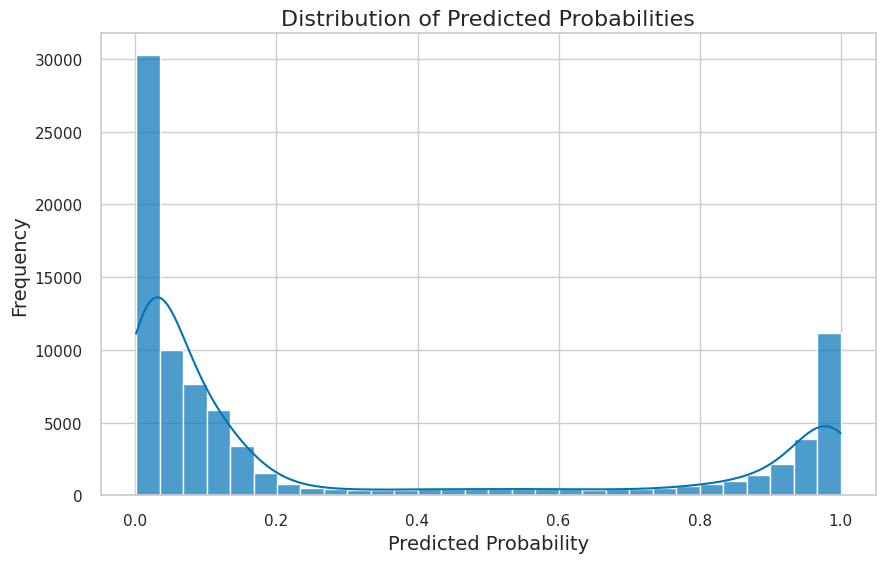

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Define the custom color
custom_color = "#0073b7"  # Replace with the HEX code of your desired color

# Plot the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(df_to_predict['PREDICTED_PROBABILITY'], bins=30, kde=True, color=custom_color, alpha=0.7)

# Add titles and labels
plt.title("Distribution of Predicted Probabilities", fontsize=16)
plt.xlabel("Predicted Probability", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Display the plot
plt.show()


## Kmeans for dividing score band

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Lấy dữ liệu xác suất từ DataFrame
probabilities = df_to_predict['PREDICTED_PROBABILITY'].values.reshape(-1, 1)

# Áp dụng K-Means với số cụm (clusters) phù hợp
kmeans = KMeans(n_clusters=9, random_state=42)
df_to_predict['CLUSTER'] = kmeans.fit_predict(probabilities)

# Kiểm tra trung tâm các cụm để hiểu cách phân nhóm
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers: ", cluster_centers)


Cluster Centers:  [[0.08668339]
 [0.81162322]
 [0.16295532]
 [0.50065275]
 [0.98561689]
 [0.02195455]
 [0.66162352]
 [0.33052912]
 [0.91704989]]


<ipython-input-176-8036e319a54d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_predict['CLUSTER'] = kmeans.fit_predict(probabilities)


In [ ]:
# Sắp xếp cụm theo giá trị trung tâm để gán nhãn từ 'AAA' đến 'C'
cluster_order = np.argsort(cluster_centers.flatten())
score_labels = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C']  # Bạn có thể thay đổi nhãn theo nhu cầu

# Tạo map để chuyển cụm thành nhãn
cluster_to_label = {cluster_order[i]: score_labels[i] for i in range(len(score_labels))}
df_to_predict['SCORE_BAND'] = df_to_predict['CLUSTER'].map(cluster_to_label)

# Xóa cột 'CLUSTER' nếu không cần thiết
df_to_predict.drop(columns=['CLUSTER'], inplace=True)

# Kiểm tra kết quả
print(df_to_predict[['PREDICTED_PROBABILITY', 'SCORE_BAND']].head())


    PREDICTED_PROBABILITY SCORE_BAND
9                0.062768         AA
19               0.736009          B
29               0.068563         AA
39               0.148154          A
49               0.982658          C


<ipython-input-177-10f91200ac7a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_predict['SCORE_BAND'] = df_to_predict['CLUSTER'].map(cluster_to_label)
<ipython-input-177-10f91200ac7a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_predict.drop(columns=['CLUSTER'], inplace=True)


<ipython-input-195-003872e8117a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_predict['TEMP_SCORE_BAND'] = df_to_predict.apply(adjust_score_band, axis=1)
<ipython-input-195-003872e8117a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_predict['ADJUSTED_SCORE_BAND'] = df_to_predict.apply(adjust_high_risk_to_lower, axis=1)
<ipython-input-195-003872e8117a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

ADJUSTED_SCORE_BAND
AAA    34441
C      13306
AA     11073
CC      9355
CCC     8921
B       3181
A       2676
BBB     2605
BB      1900
Name: count, dtype: int64


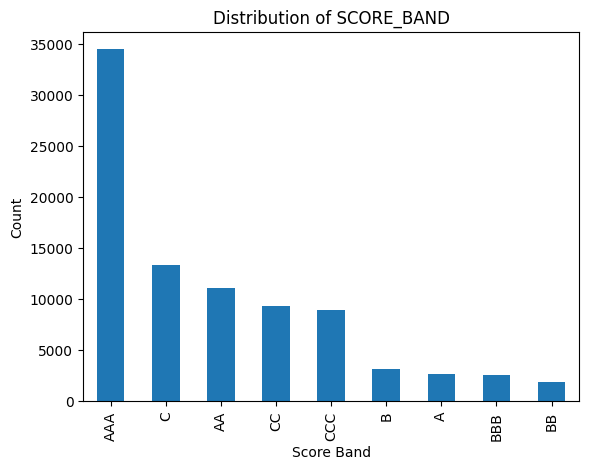

In [ ]:
# Hàm điều chỉnh SCORE_BAND với nhóm AAA, AA, A và nhóm rủi ro cao
def adjust_score_band(row):
    # Điều chỉnh nhóm rủi ro cao nhất
    if row['OVER_DUE_DAYS_LD'] > 200 or row['TOTAL_OVERDUE_PERIOD'] > 10:
        return 'C'
    elif row['OVER_DUE_DAYS_LD'] > 150 or row['TOTAL_OVERDUE_PERIOD'] > 8:
        return 'CC'
    elif row['OVER_DUE_DAYS_LD'] > 100 or row['TOTAL_OVERDUE_PERIOD'] > 6:
        return 'CCC'
    return row['SCORE_BAND']

# Áp dụng quy tắc điều chỉnh bước đầu
df_to_predict['TEMP_SCORE_BAND'] = df_to_predict.apply(adjust_score_band, axis=1)

# Hàm điều chỉnh nhóm rủi ro cao xuống nhóm thấp hơn nếu các giá trị thấp
def adjust_high_risk_to_lower(row):
    if row['TEMP_SCORE_BAND'] in ['CCC', 'CC', 'C']:  # Chỉ điều chỉnh nhóm rủi ro cao
        if row['OVER_DUE_DAYS_LD'] <= 50 and row['TOTAL_OVERDUE_PERIOD'] <= 4:
            return 'BBB'
        elif row['OVER_DUE_DAYS_LD'] <= 70 and row['TOTAL_OVERDUE_PERIOD'] <= 5:
            return 'BB'
        elif row['OVER_DUE_DAYS_LD'] <= 100 and row['TOTAL_OVERDUE_PERIOD'] <= 6:
            return 'B'
    return row['TEMP_SCORE_BAND']  # Giữ nguyên nếu không thuộc nhóm cần điều chỉnh

# Áp dụng quy tắc điều chỉnh nhóm rủi ro cao
df_to_predict['ADJUSTED_SCORE_BAND'] = df_to_predict.apply(adjust_high_risk_to_lower, axis=1)

# Xóa cột tạm nếu không cần thiết
df_to_predict.drop(columns=['TEMP_SCORE_BAND'], inplace=True)

# Kiểm tra phân phối các nhóm sau điều chỉnh
adjusted_distribution = df_to_predict['ADJUSTED_SCORE_BAND'].value_counts()
print(adjusted_distribution)

# Trực quan hóa kết quả
df_to_predict['ADJUSTED_SCORE_BAND'].value_counts().plot(kind='bar')
plt.title("Distribution of SCORE_BAND")
plt.xlabel("Score Band")
plt.ylabel("Count")
plt.show()


## Visualization

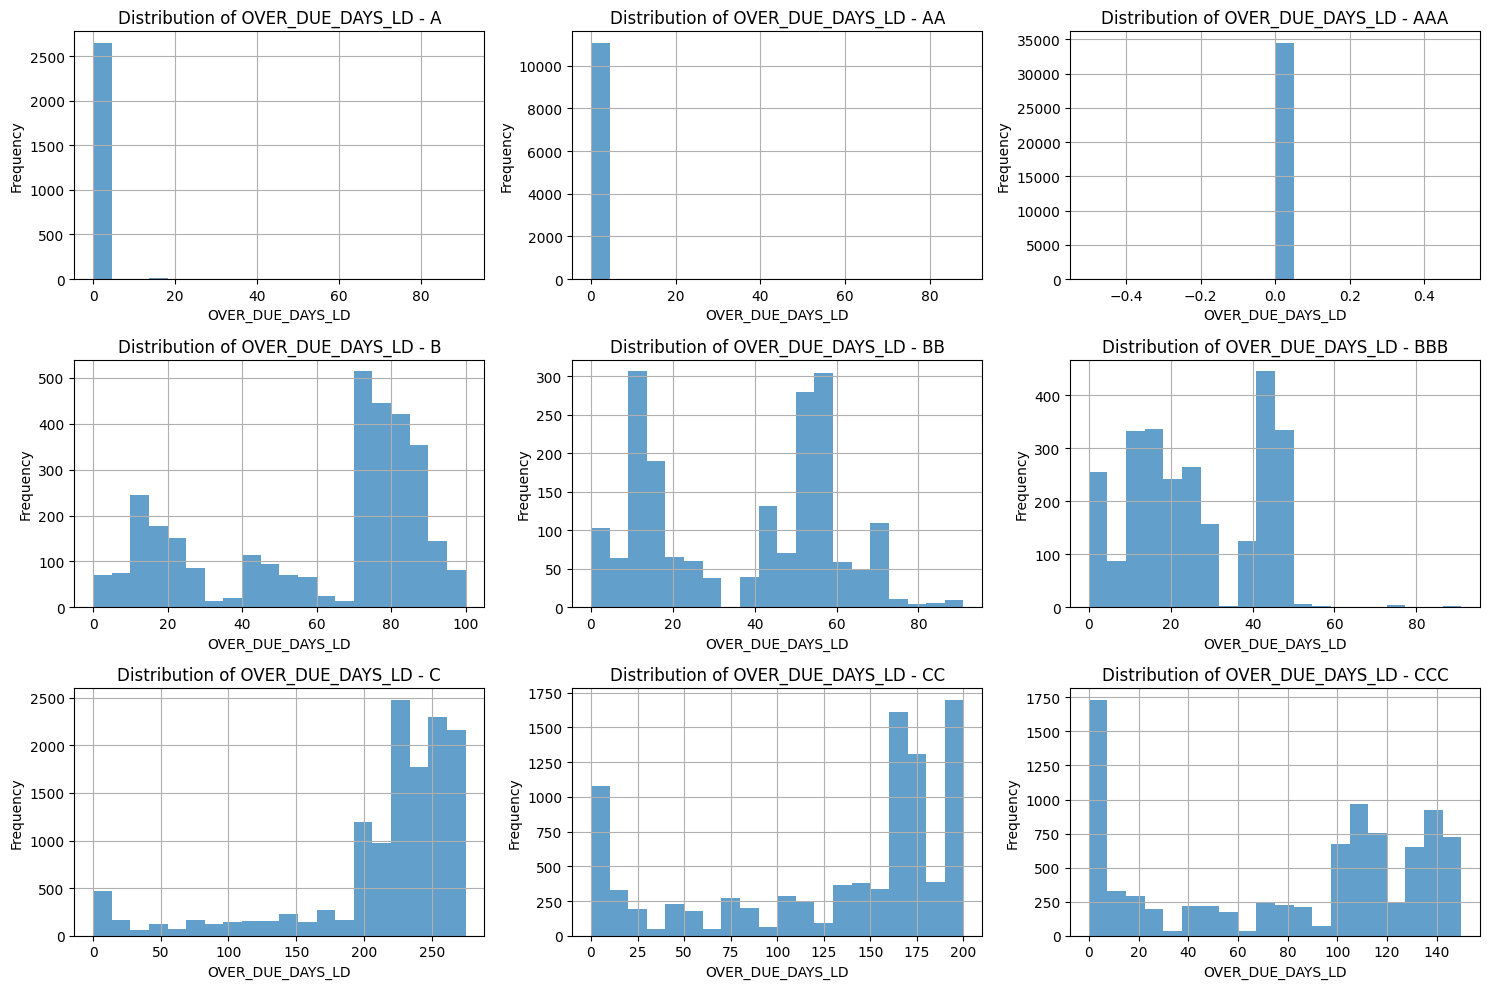

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo biểu đồ phân phối cho từng nhóm SCORE_BAND
score_bands = df_to_predict['ADJUSTED_SCORE_BAND'].unique()  # Các nhóm từ AAA đến C

# Thiết lập kích thước tổng thể
plt.figure(figsize=(15, 10))

# Lặp qua từng nhóm và vẽ histogram
for i, band in enumerate(sorted(score_bands), 1):
    plt.subplot(3, 3, i)  # Bố trí lưới 3x3 (có thể điều chỉnh nếu số nhóm khác)
    df_to_predict['OVER_DUE_DAYS_LD'][df_to_predict['ADJUSTED_SCORE_BAND'] == band].hist(bins=20, alpha=0.7)
    plt.title(f"Distribution of OVER_DUE_DAYS_LD - {band}")
    plt.xlabel('OVER_DUE_DAYS_LD')
    plt.ylabel('Frequency')

plt.tight_layout()  # Tự động căn chỉnh các biểu đồ
plt.show()


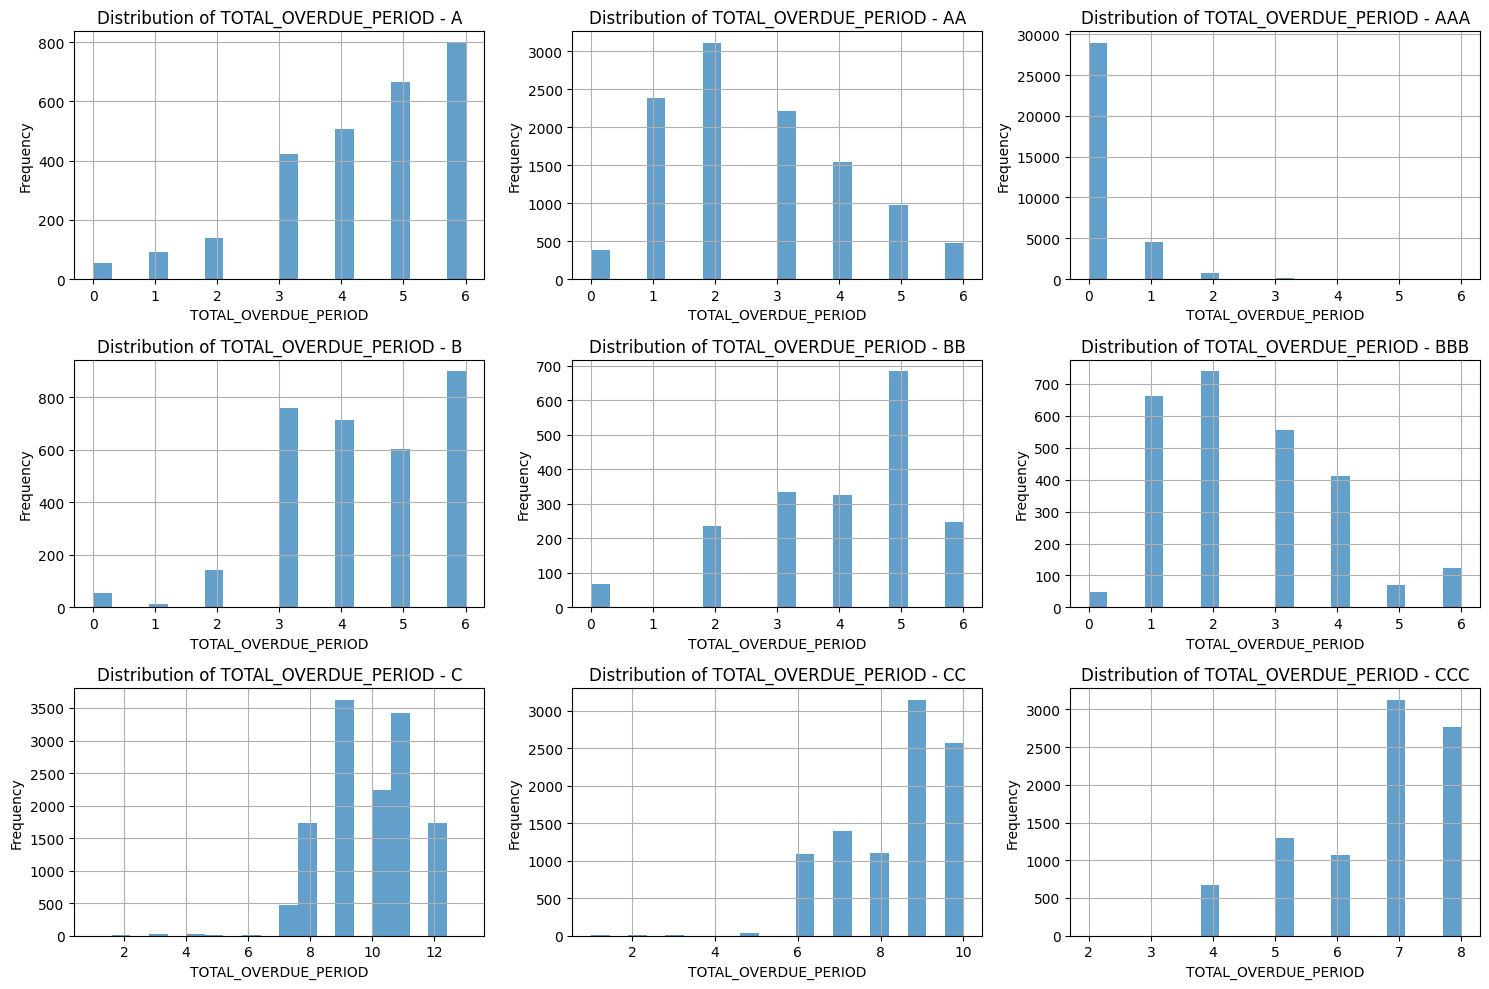

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo biểu đồ phân phối cho từng nhóm SCORE_BAND
score_bands = df_to_predict['ADJUSTED_SCORE_BAND'].unique()  # Các nhóm từ AAA đến C

# Thiết lập kích thước tổng thể
plt.figure(figsize=(15, 10))

# Lặp qua từng nhóm và vẽ histogram
for i, band in enumerate(sorted(score_bands), 1):
    plt.subplot(3, 3, i)  # Bố trí lưới 3x3 (có thể điều chỉnh nếu số nhóm khác)
    df_to_predict['TOTAL_OVERDUE_PERIOD'][df_to_predict['ADJUSTED_SCORE_BAND'] == band].hist(bins=20, alpha=0.7)
    plt.title(f"Distribution of TOTAL_OVERDUE_PERIOD - {band}")
    plt.xlabel('TOTAL_OVERDUE_PERIOD')
    plt.ylabel('Frequency')

plt.tight_layout()  # Tự động căn chỉnh các biểu đồ
plt.show()


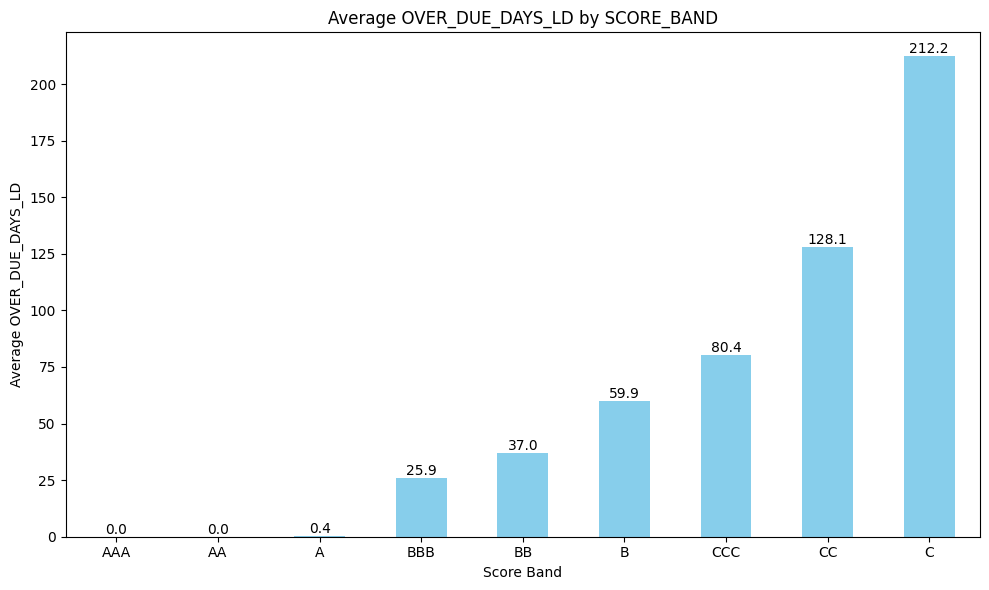

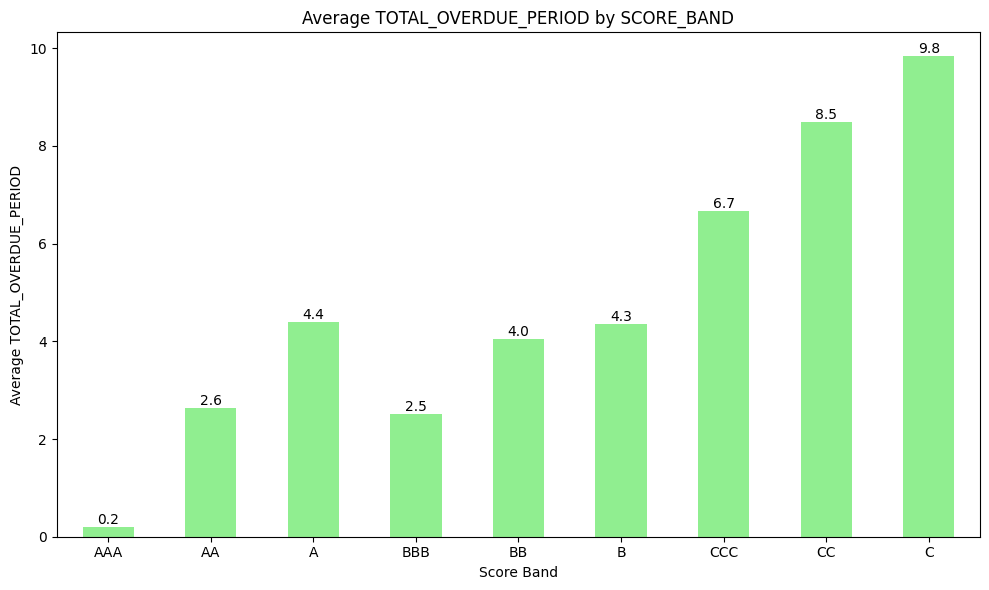

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Tạo thứ tự nhóm cụ thể
score_band_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C']

# Tính giá trị trung bình của OVER_DUE_DAYS_LD và TOTAL_OVERDUE_PERIOD theo nhóm
average_metrics = df_to_predict.groupby('ADJUSTED_SCORE_BAND')[['OVER_DUE_DAYS_LD', 'TOTAL_OVERDUE_PERIOD']].mean()

# Sắp xếp theo thứ tự cụ thể
average_metrics = average_metrics.reindex(score_band_order)

# Biểu đồ 1: Average_OVER_DUE_DAYS_LD
plt.figure(figsize=(10, 6))
ax = average_metrics['OVER_DUE_DAYS_LD'].plot(kind='bar', color='skyblue', legend=False)
plt.title('Average OVER_DUE_DAYS_LD by SCORE_BAND')
plt.xlabel('Score Band')
plt.ylabel('Average OVER_DUE_DAYS_LD')
plt.xticks(rotation=0)
plt.tight_layout()

# Thêm số ở trên mỗi cột
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.show()

# Biểu đồ 2: Average_TOTAL_OVERDUE_PERIOD
plt.figure(figsize=(10, 6))
ax = average_metrics['TOTAL_OVERDUE_PERIOD'].plot(kind='bar', color='lightgreen', legend=False)
plt.title('Average TOTAL_OVERDUE_PERIOD by SCORE_BAND')
plt.xlabel('Score Band')
plt.ylabel('Average TOTAL_OVERDUE_PERIOD')
plt.xticks(rotation=0)
plt.tight_layout()

# Thêm số ở trên mỗi cột
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.show()


## **4. Clustering**

## Feature Selection

In [ ]:
df_to_predict.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87458 entries, 9 to 1030019
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   IS_ROLL_UP                     0 non-null      float64
 1   MARITAL_STATUS                 87458 non-null  float64
 2   Age                            87458 non-null  float64
 3   NUMBER_OF_DEPENDANTS           87458 non-null  float64
 4   CUSTOMER_INCOME                87458 non-null  float64
 5   WORKING_IN_YEAR                87458 non-null  float64
 6   LOAN_AMOUNT                    87458 non-null  float64
 7   LOAN_TERM                      87458 non-null  float64
 8   MONTH_INTEREST                 87458 non-null  float64
 9   PRODUCT_CATEGORY               87458 non-null  float64
 10  LOAN_PURPOSE                   87458 non-null  float64
 11  MONTH_ON_BOOK                  87458 non-null  float64
 12  TOTAL_EMI_AMOUNT               87458 non-null  fl

In [ ]:
df_kmeans = df_to_predict.copy()

In [ ]:
df_kmeans.drop(columns=['PREDICTED_PROBABILITY', 'IS_ROLL_UP'], inplace=True)

In [ ]:
# Redefine the DPD bucket classification function, as the environment has reset
def classify_numberic_dpd_bucket(days_overdue):
    if days_overdue == 0:
        return 0
    elif 1 <= days_overdue <= 9:
        return 1
    elif 10 <= days_overdue <= 30:
        return 2
    elif 31 <= days_overdue <= 60:
        return 3
    elif 61 <= days_overdue <= 90:
        return 4
    elif 91 <= days_overdue <= 120:
        return 5
    elif 121 <= days_overdue <= 150:
        return 6
    elif 151 <= days_overdue <= 180:
        return 7
    elif 181 <= days_overdue <= 210:
        return 8
    elif 211 <= days_overdue <= 240:
        return 9
    elif 241 <= days_overdue <= 270:
        return 10
    elif 271 <= days_overdue <= 300:
        return 11
    elif 301 <= days_overdue <= 330:
        return 12
    elif 331 <= days_overdue <= 360:
        return 13
    else:
        return 14
# Apply the DPD bucket classification function to the new data
df_kmeans['NUMBERIC_DPD_BUCKET'] = df_kmeans['OVER_DUE_DAYS_LD'].apply(classify_numberic_dpd_bucket)


In [ ]:
# Encode SCORE_BAND column
score_map = {'AAA': 9, 'AA': 8, 'A': 7, 'BBB': 6, 'BB': 5, 'B': 4, 'CCC': 3, 'CC': 2, 'C': 1}
df_kmeans['SCORE_BAND_NUMERIC'] = df_kmeans['SCORE_BAND'].map(score_map)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Select the relevant features for clustering
features = [
    # Demographic
    'Age',
    'NUMBER_OF_DEPENDANTS',
    'CUSTOMER_INCOME',
    'WORKING_IN_YEAR',

    # Loan Information
    'LOAN_AMOUNT',
    'LOAN_TERM',

    # Loan Repayment
    'TOTAL_EMI_AMOUNT',
    # 'LAST_PAYMENT_AMOUNT',
    'OUTSTANDING',
    # 'OVER_DUE_DAYS_LD',
    'NUMBERIC_DPD_BUCKET',
    'TOTAL_OVERDUE_PERIOD',
    # 'PRI_PAST_DUE',
    # 'INT_PAST_DUE',
    'OD_PAST_DUE',

    'SCORE_BAND_NUMERIC'

]

# Subset the data to include only the relevant features
data_subset = df_kmeans[features]

# Scale the data using StandardScaler
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_subset), columns=features)

# Display the first few rows of the preprocessed data
data_scaled.head()


,Age,NUMBER_OF_DEPENDANTS,CUSTOMER_INCOME,WORKING_IN_YEAR,LOAN_AMOUNT,LOAN_TERM,TOTAL_EMI_AMOUNT,OUTSTANDING,NUMBERIC_DPD_BUCKET,TOTAL_OVERDUE_PERIOD,OD_PAST_DUE,SCORE_BAND_NUMERIC
0,-0.491166,-0.634519,0.737989,-0.223092,0.695994,0.470170,0.243619,0.465000,-0.719312,-0.752072,-0.600876,0.478839
1,-0.915173,-0.634519,0.458782,-0.757986,-0.828611,-0.374307,-0.674227,-0.509284,0.142691,1.032873,-0.248224,-0.819330
2,1.946876,0.505967,0.627421,2.629678,0.300183,1.314646,-0.593753,0.317661,-0.719312,-0.497080,-0.600876,0.478839
3,-0.597168,-0.634519,-0.695053,-0.044794,0.285524,-0.374307,0.173010,0.557330,2.154032,1.032873,2.083252,0.154297
4,-0.173161,1.646453,0.800181,-0.757986,0.643209,1.314646,0.340700,1.136387,0.717360,0.522889,0.280747,-1.792957


## Optimal K

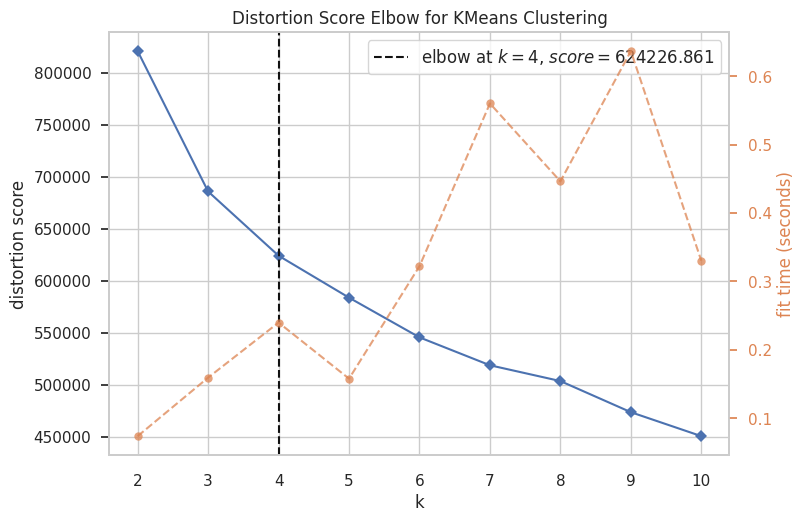

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

Elbow_M = KElbowVisualizer(KMeans(), k=10, metric='distortion', random_state = 42)
Elbow_M.fit(data_scaled)
Elbow_M.show()

In [ ]:
k = 4  # optimal K
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(data_scaled)

# Get cluster labels for each customer
data_scaled['Cluster'] = kmeans.labels_

# View the cluster centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=features)
print(cluster_centers)


        Age  NUMBER_OF_DEPENDANTS  CUSTOMER_INCOME  WORKING_IN_YEAR  \
0 -0.370124             -0.255788        -0.369884        -0.272928   
1  0.482523              0.324104         0.535113         0.420577   
2 -0.204456             -0.131474        -0.310264        -0.185667   
3  0.144043              0.092247         0.307734         0.076401   

   LOAN_AMOUNT  LOAN_TERM  TOTAL_EMI_AMOUNT  OUTSTANDING  NUMBERIC_DPD_BUCKET  \
0    -0.785369  -0.703083         -0.604899    -0.648536             0.976074   
1     0.993751   0.681709          0.889177     0.837033            -0.633149   
2    -0.524296  -0.305460         -0.515502    -0.616774            -0.693640   
3     0.578738   0.487825          0.498059     0.895494             1.484130   

   TOTAL_OVERDUE_PERIOD  OD_PAST_DUE  SCORE_BAND_NUMERIC  
0              0.873198     0.623023           -1.158528  
1             -0.486585    -0.569651            0.472944  
2             -0.637886    -0.598572            0.585035  
3 

## Visualization

<ipython-input-327-339cd2790b52>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Cluster', data=df_cluster,  palette="Pastel1")


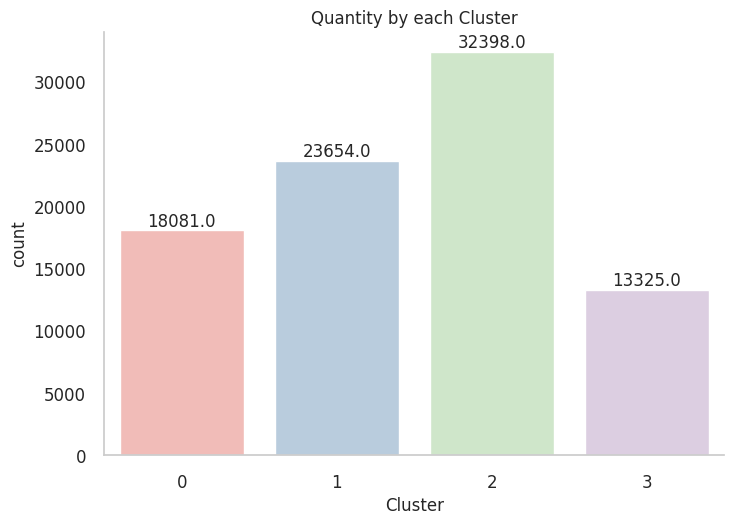

In [ ]:
df_cluster = df_kmeans.copy()

df_cluster['Cluster'] = kmeans.fit_predict(data_scaled)

ax = sns.countplot(x='Cluster', data=df_cluster,  palette="Pastel1")

# Access the patches
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    value = patch.get_height()
    text = f'{value}'  # Format the value as desired
    ax.text(x, y, text, ha='center', va='bottom')
ax.set_title('Quantity by each Cluster', size = 12)
ax.tick_params(labelsize = 12)
# Remove gridlines
sns.despine()  # Remove top and right spines
plt.grid(False)  # Remove gridlines

plt.show()

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


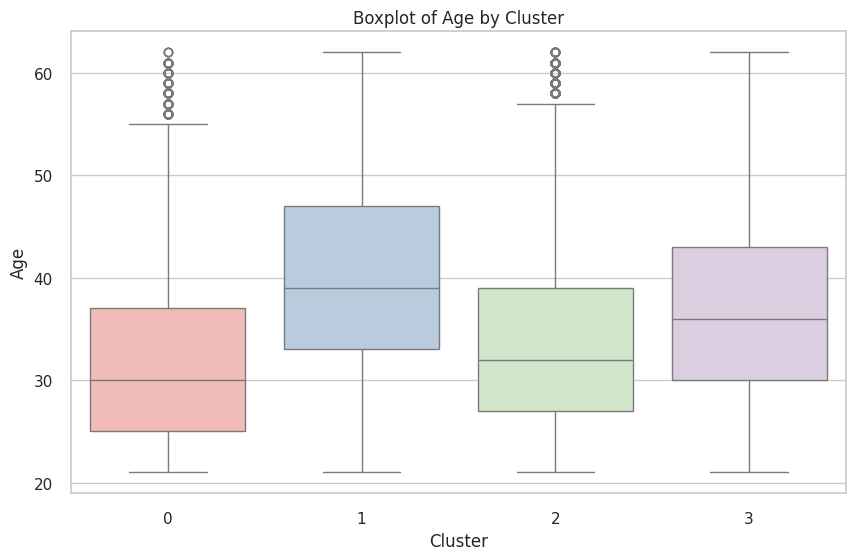

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


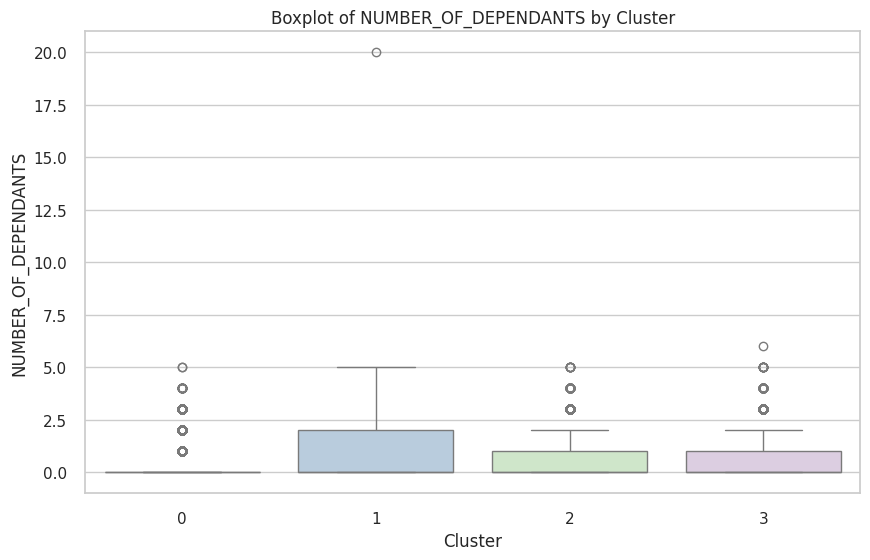

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


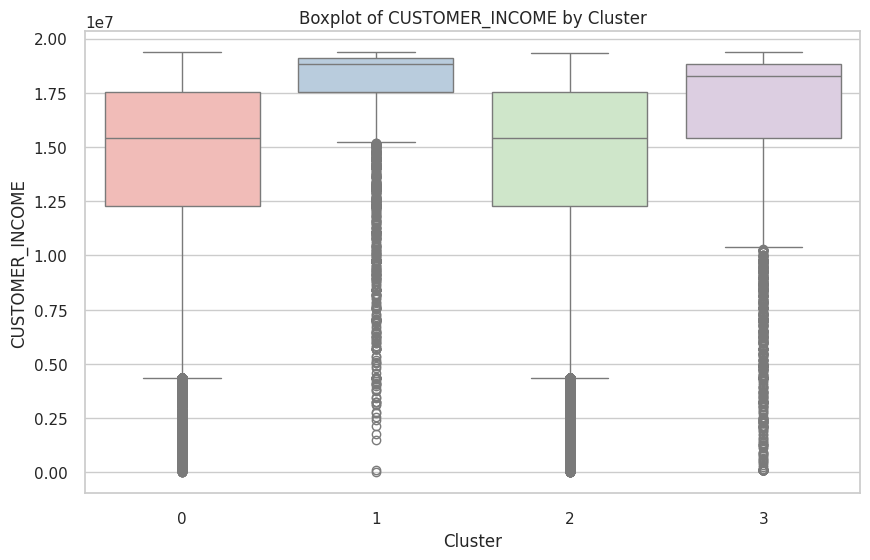

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


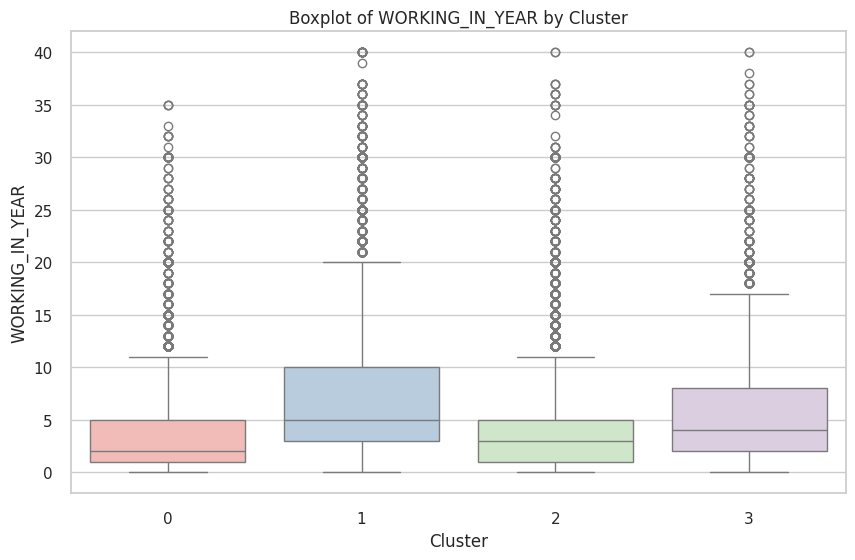

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


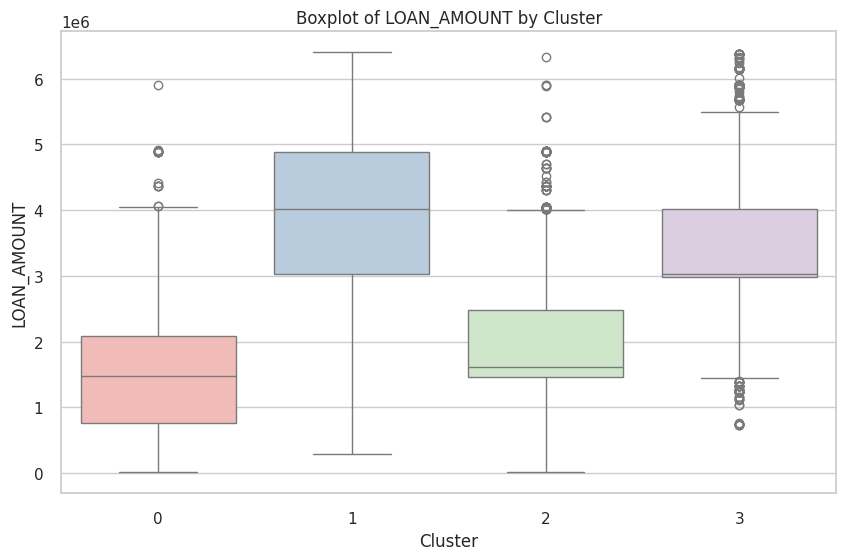

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


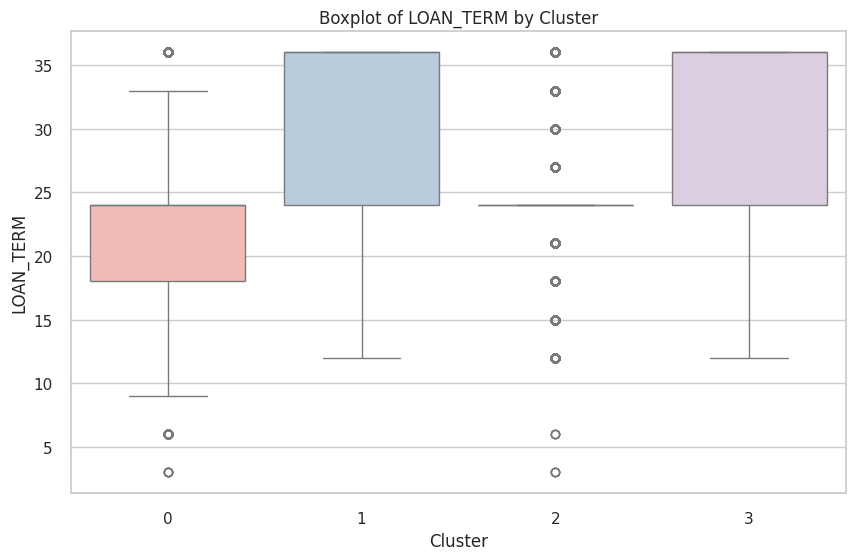

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


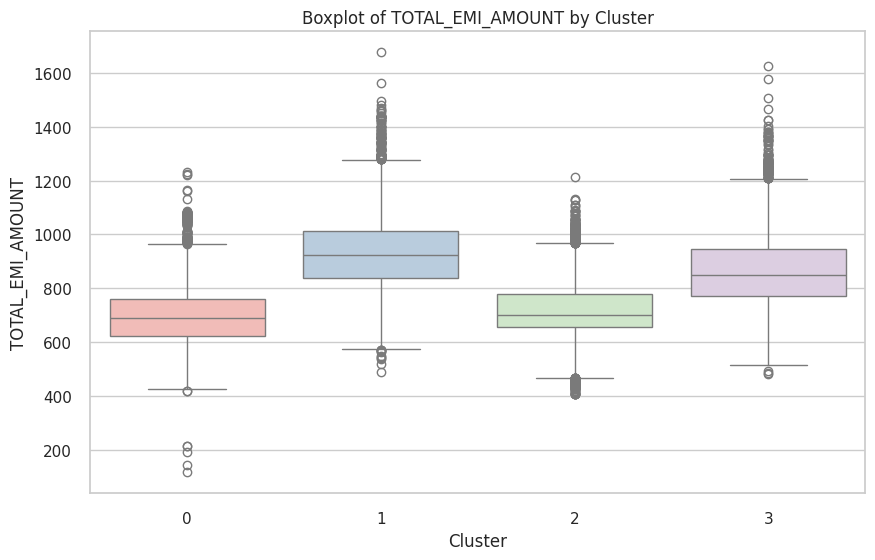

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


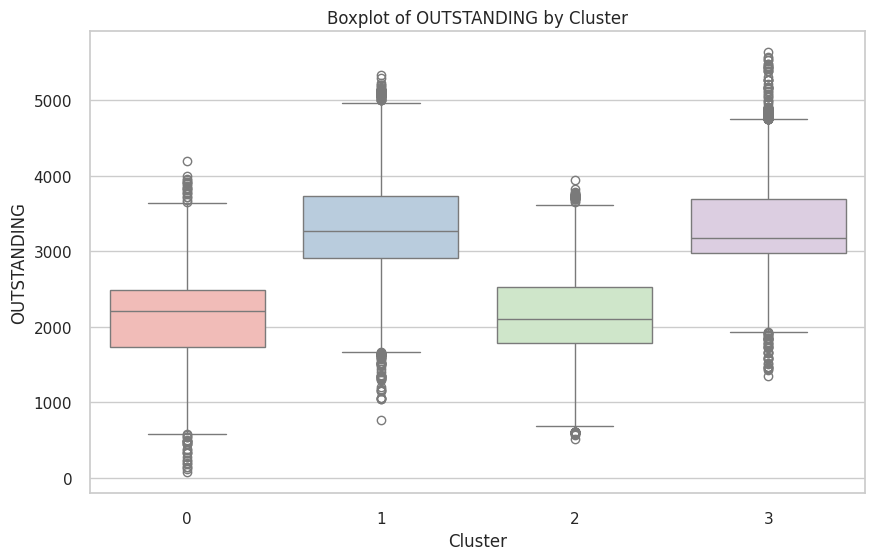

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


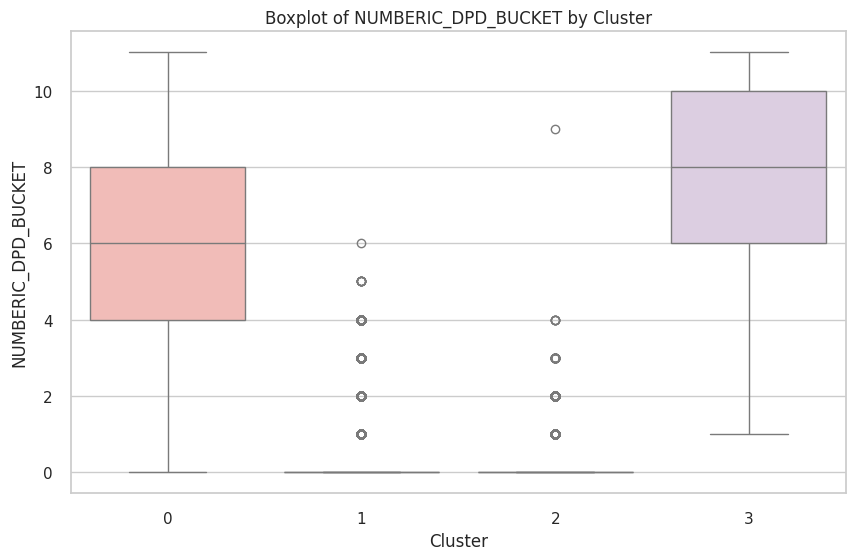

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


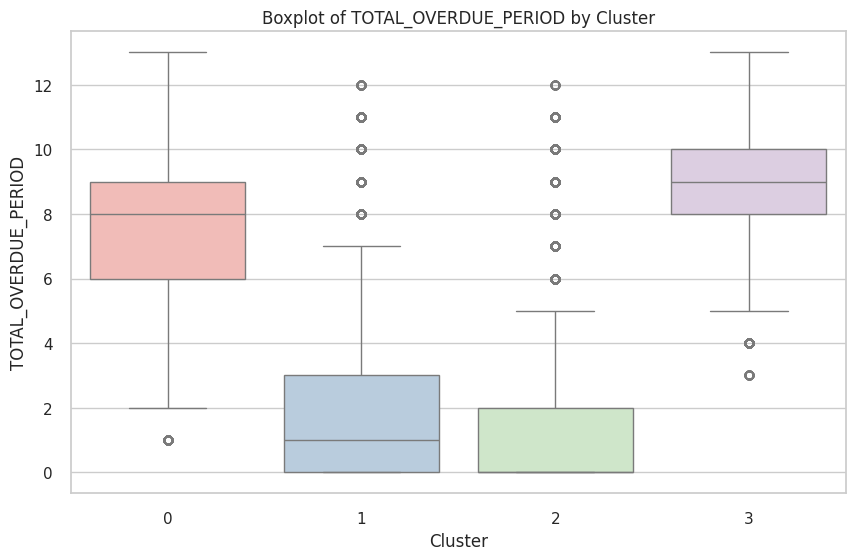

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


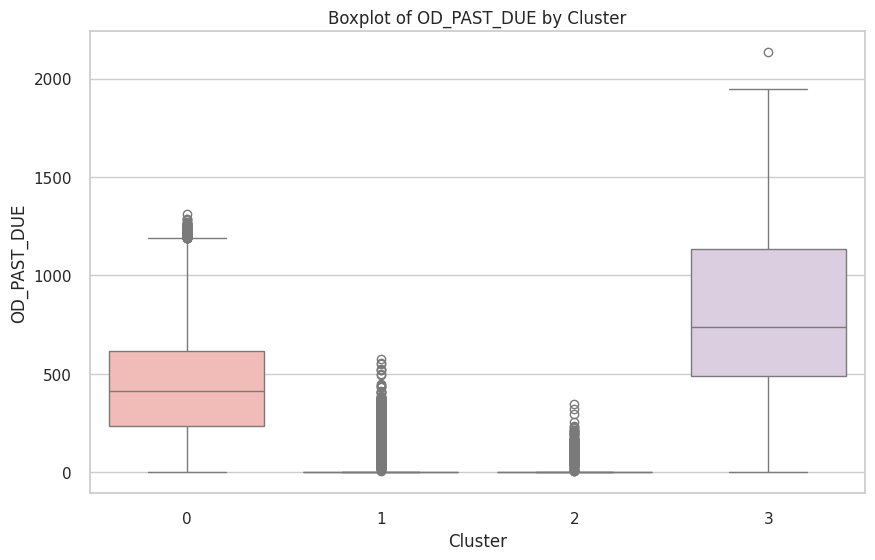

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


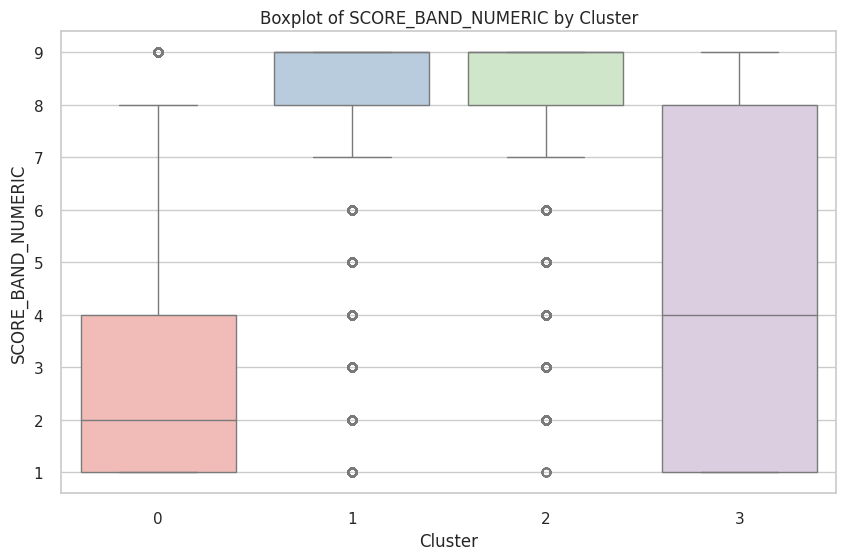

In [ ]:
# 1. Boxplot for each features by cluster
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")
    plt.title(f'Boxplot of {feature} by Cluster')
    plt.show()



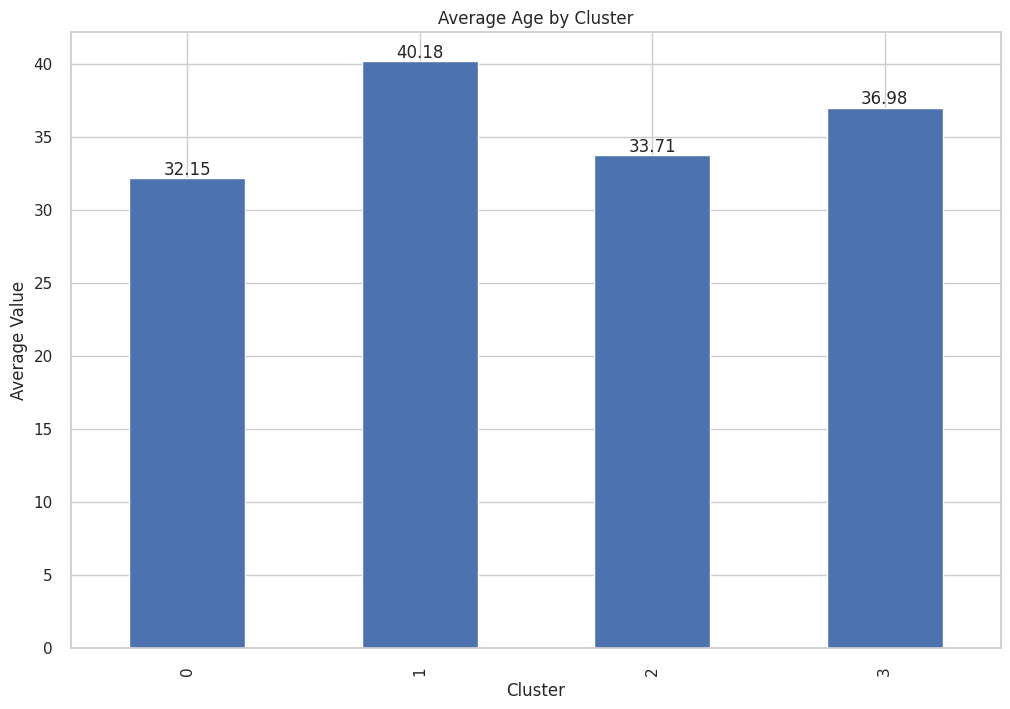

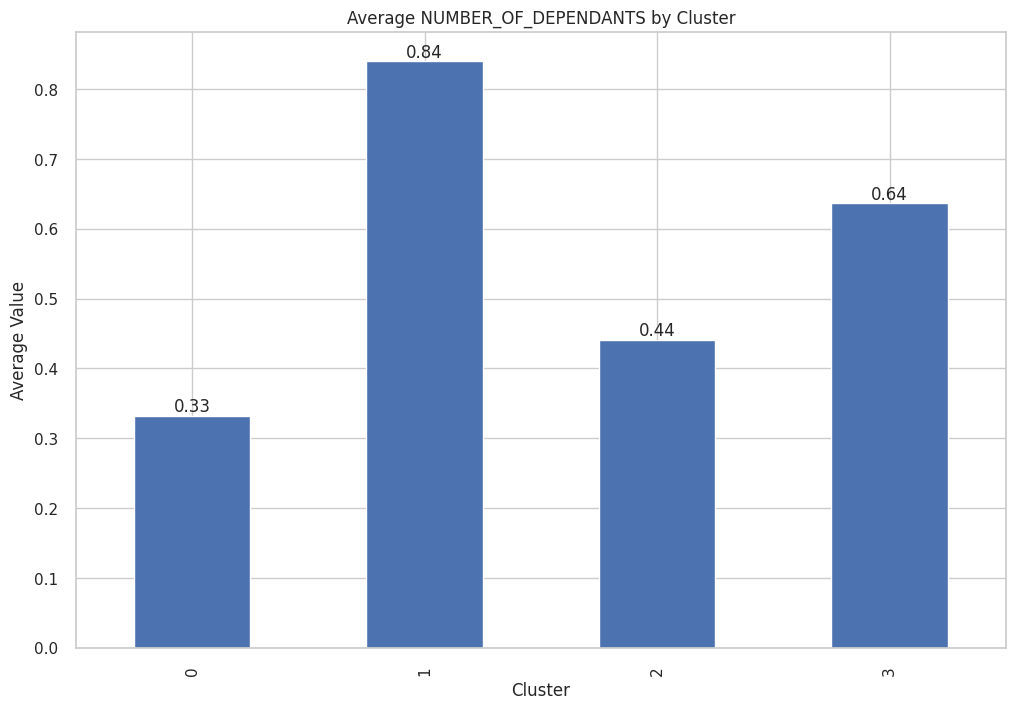

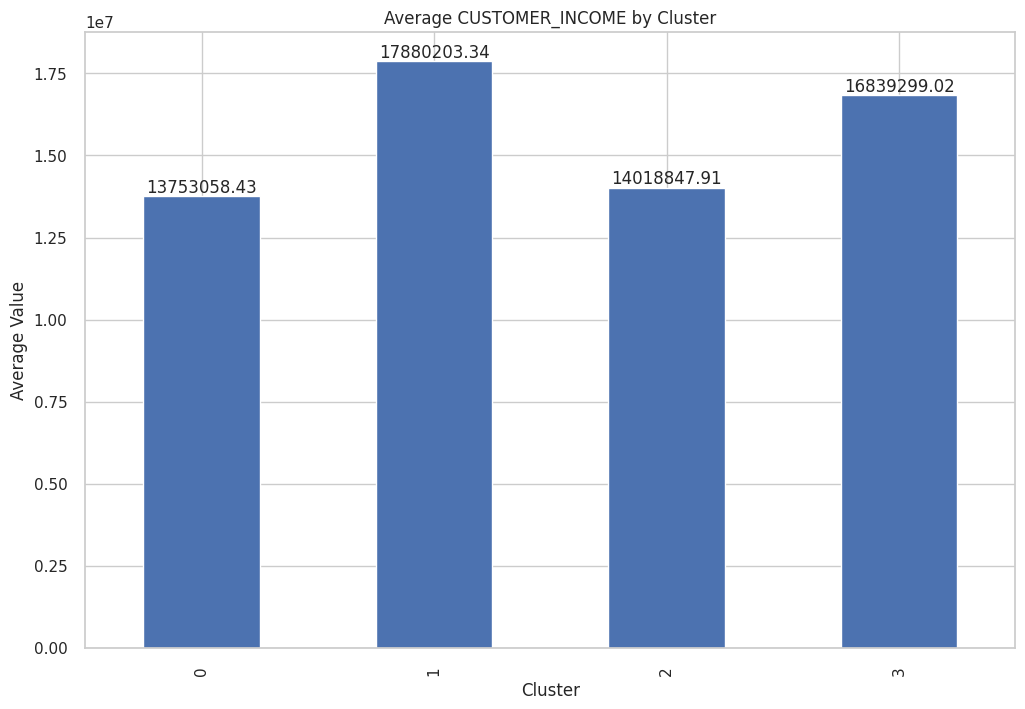

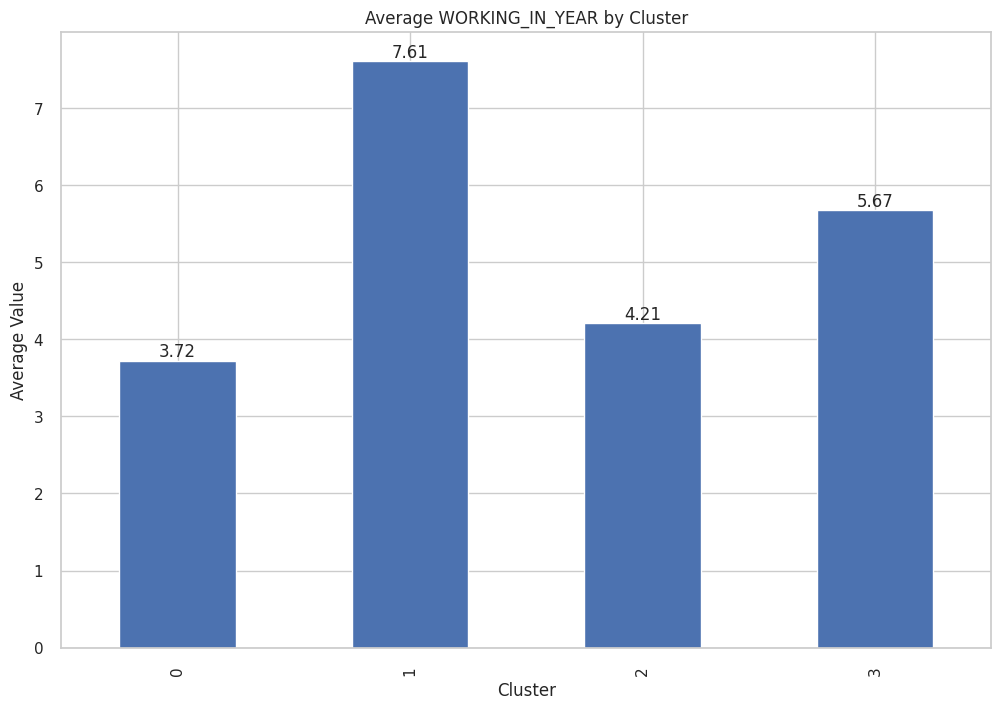

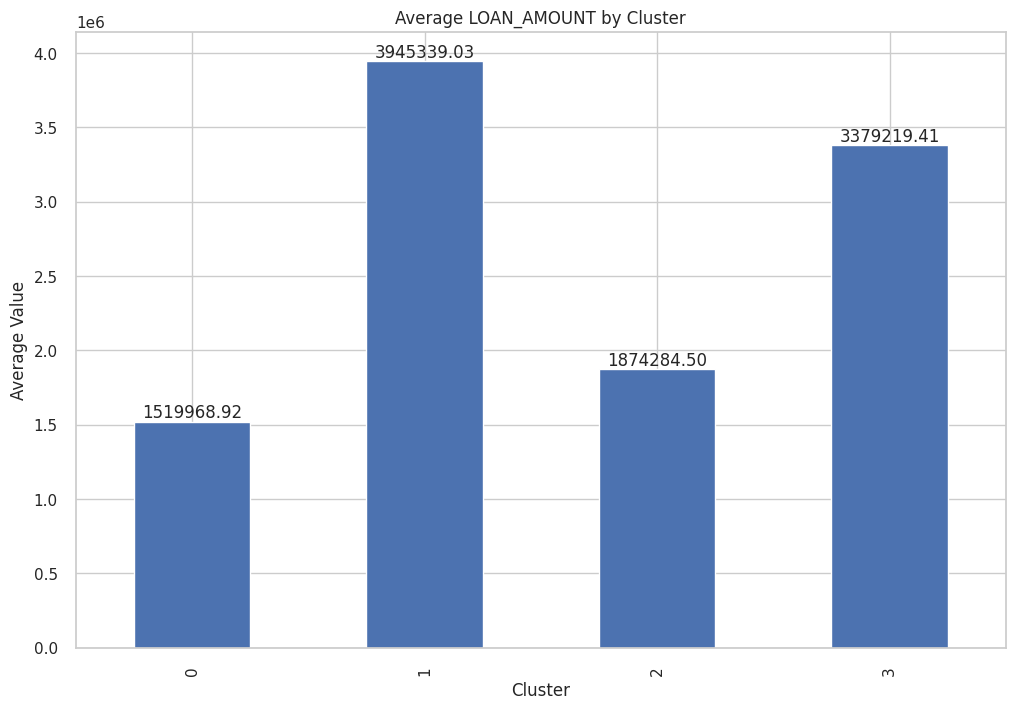

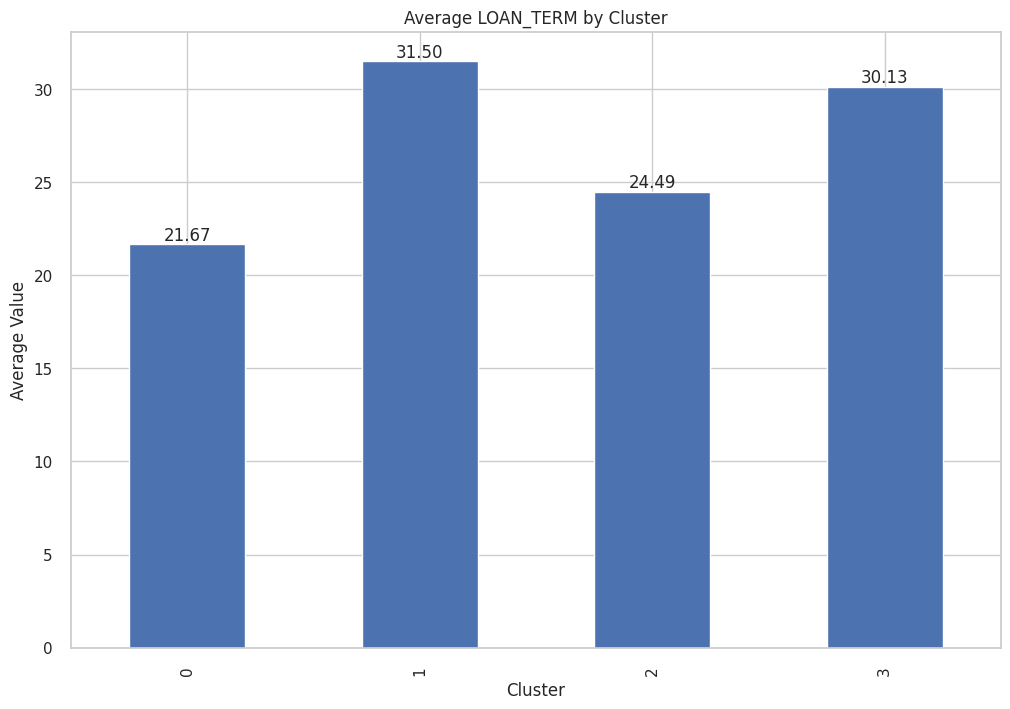

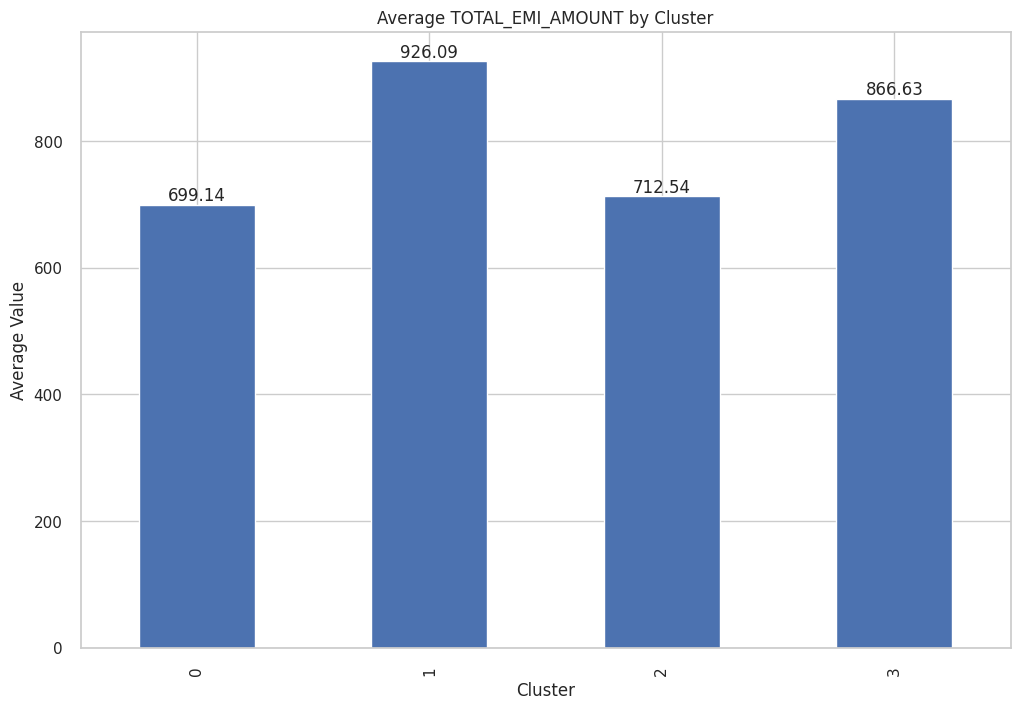

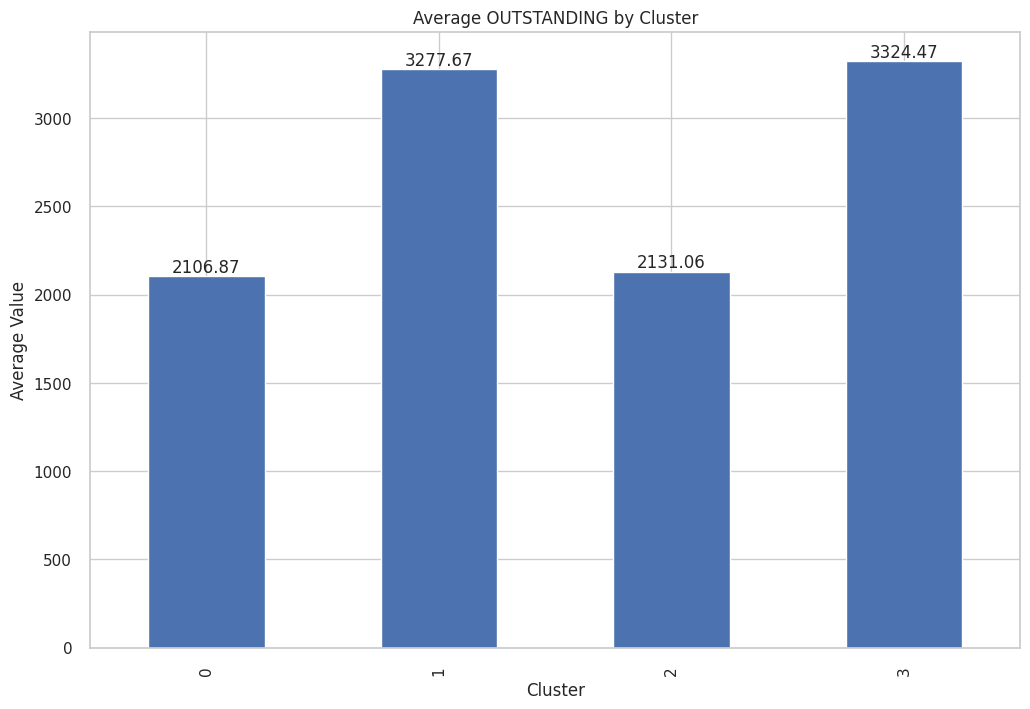

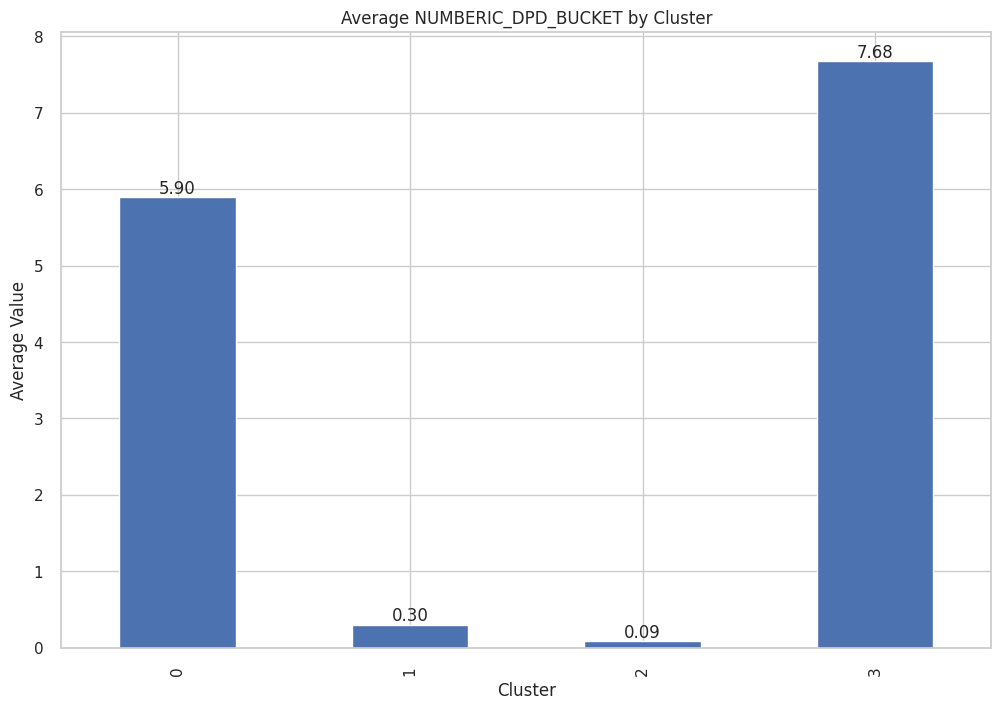

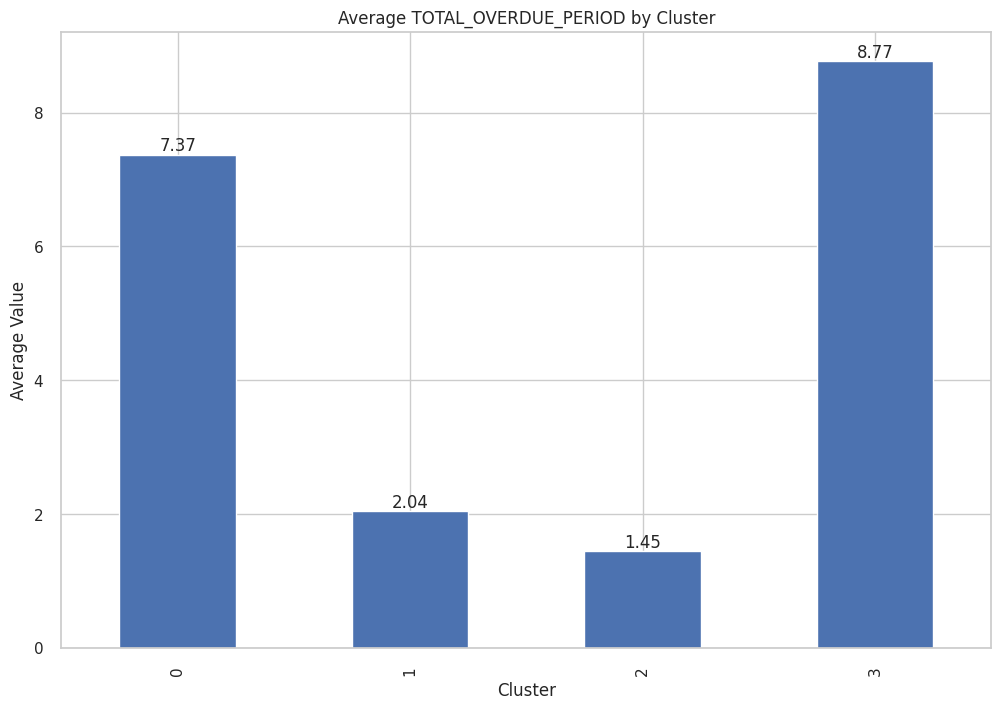

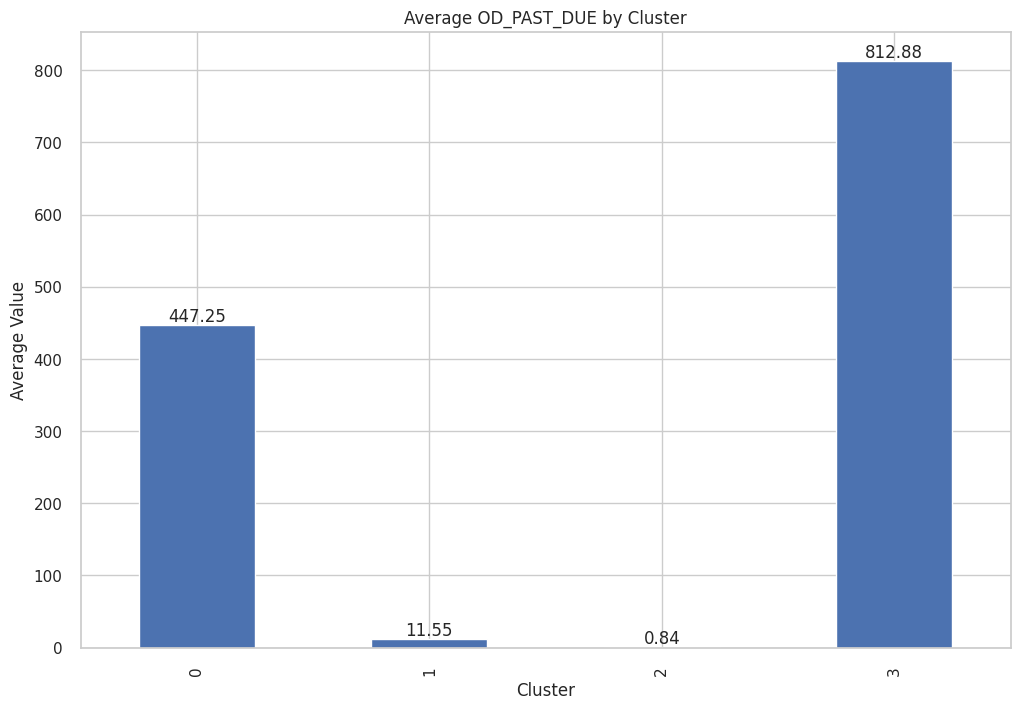

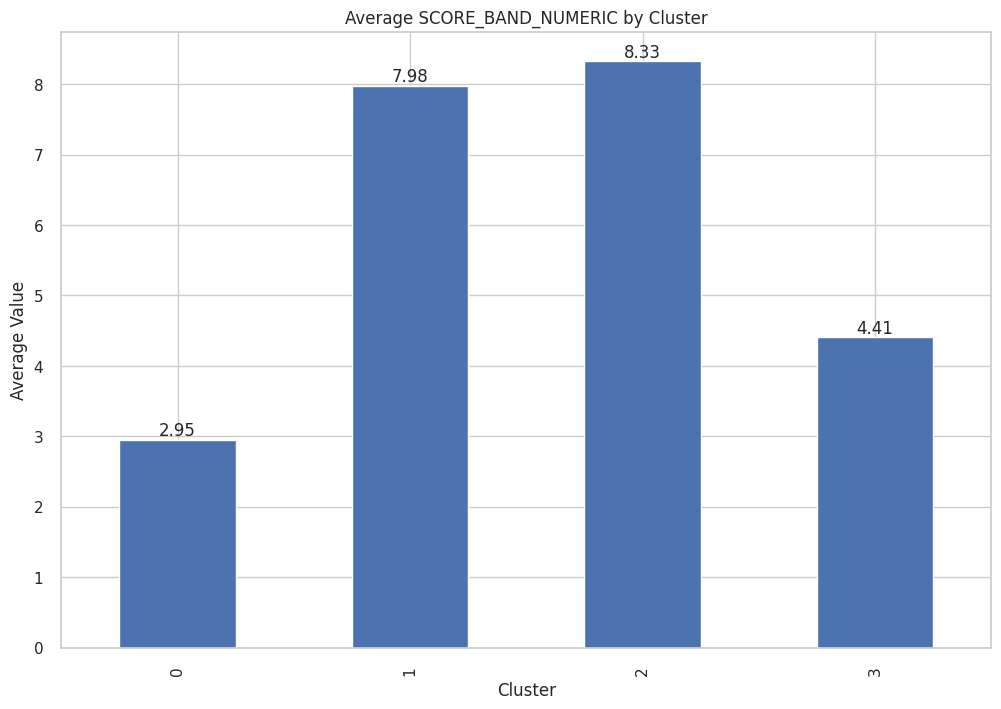

In [ ]:
import matplotlib.pyplot as plt

# Create a bar plot with data labels for each feature
for feature in features:
    # Calculate the mean values by cluster
    cluster_means = df_cluster.groupby('Cluster')[feature].mean()

    # Create the bar plot
    plt.figure(figsize=(12, 8))
    ax = cluster_means.plot(kind='bar')
    plt.title(f'Average {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Average Value')

    # Add data labels to each bar
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f')  # Format the labels to 2 decimal places

    plt.show()


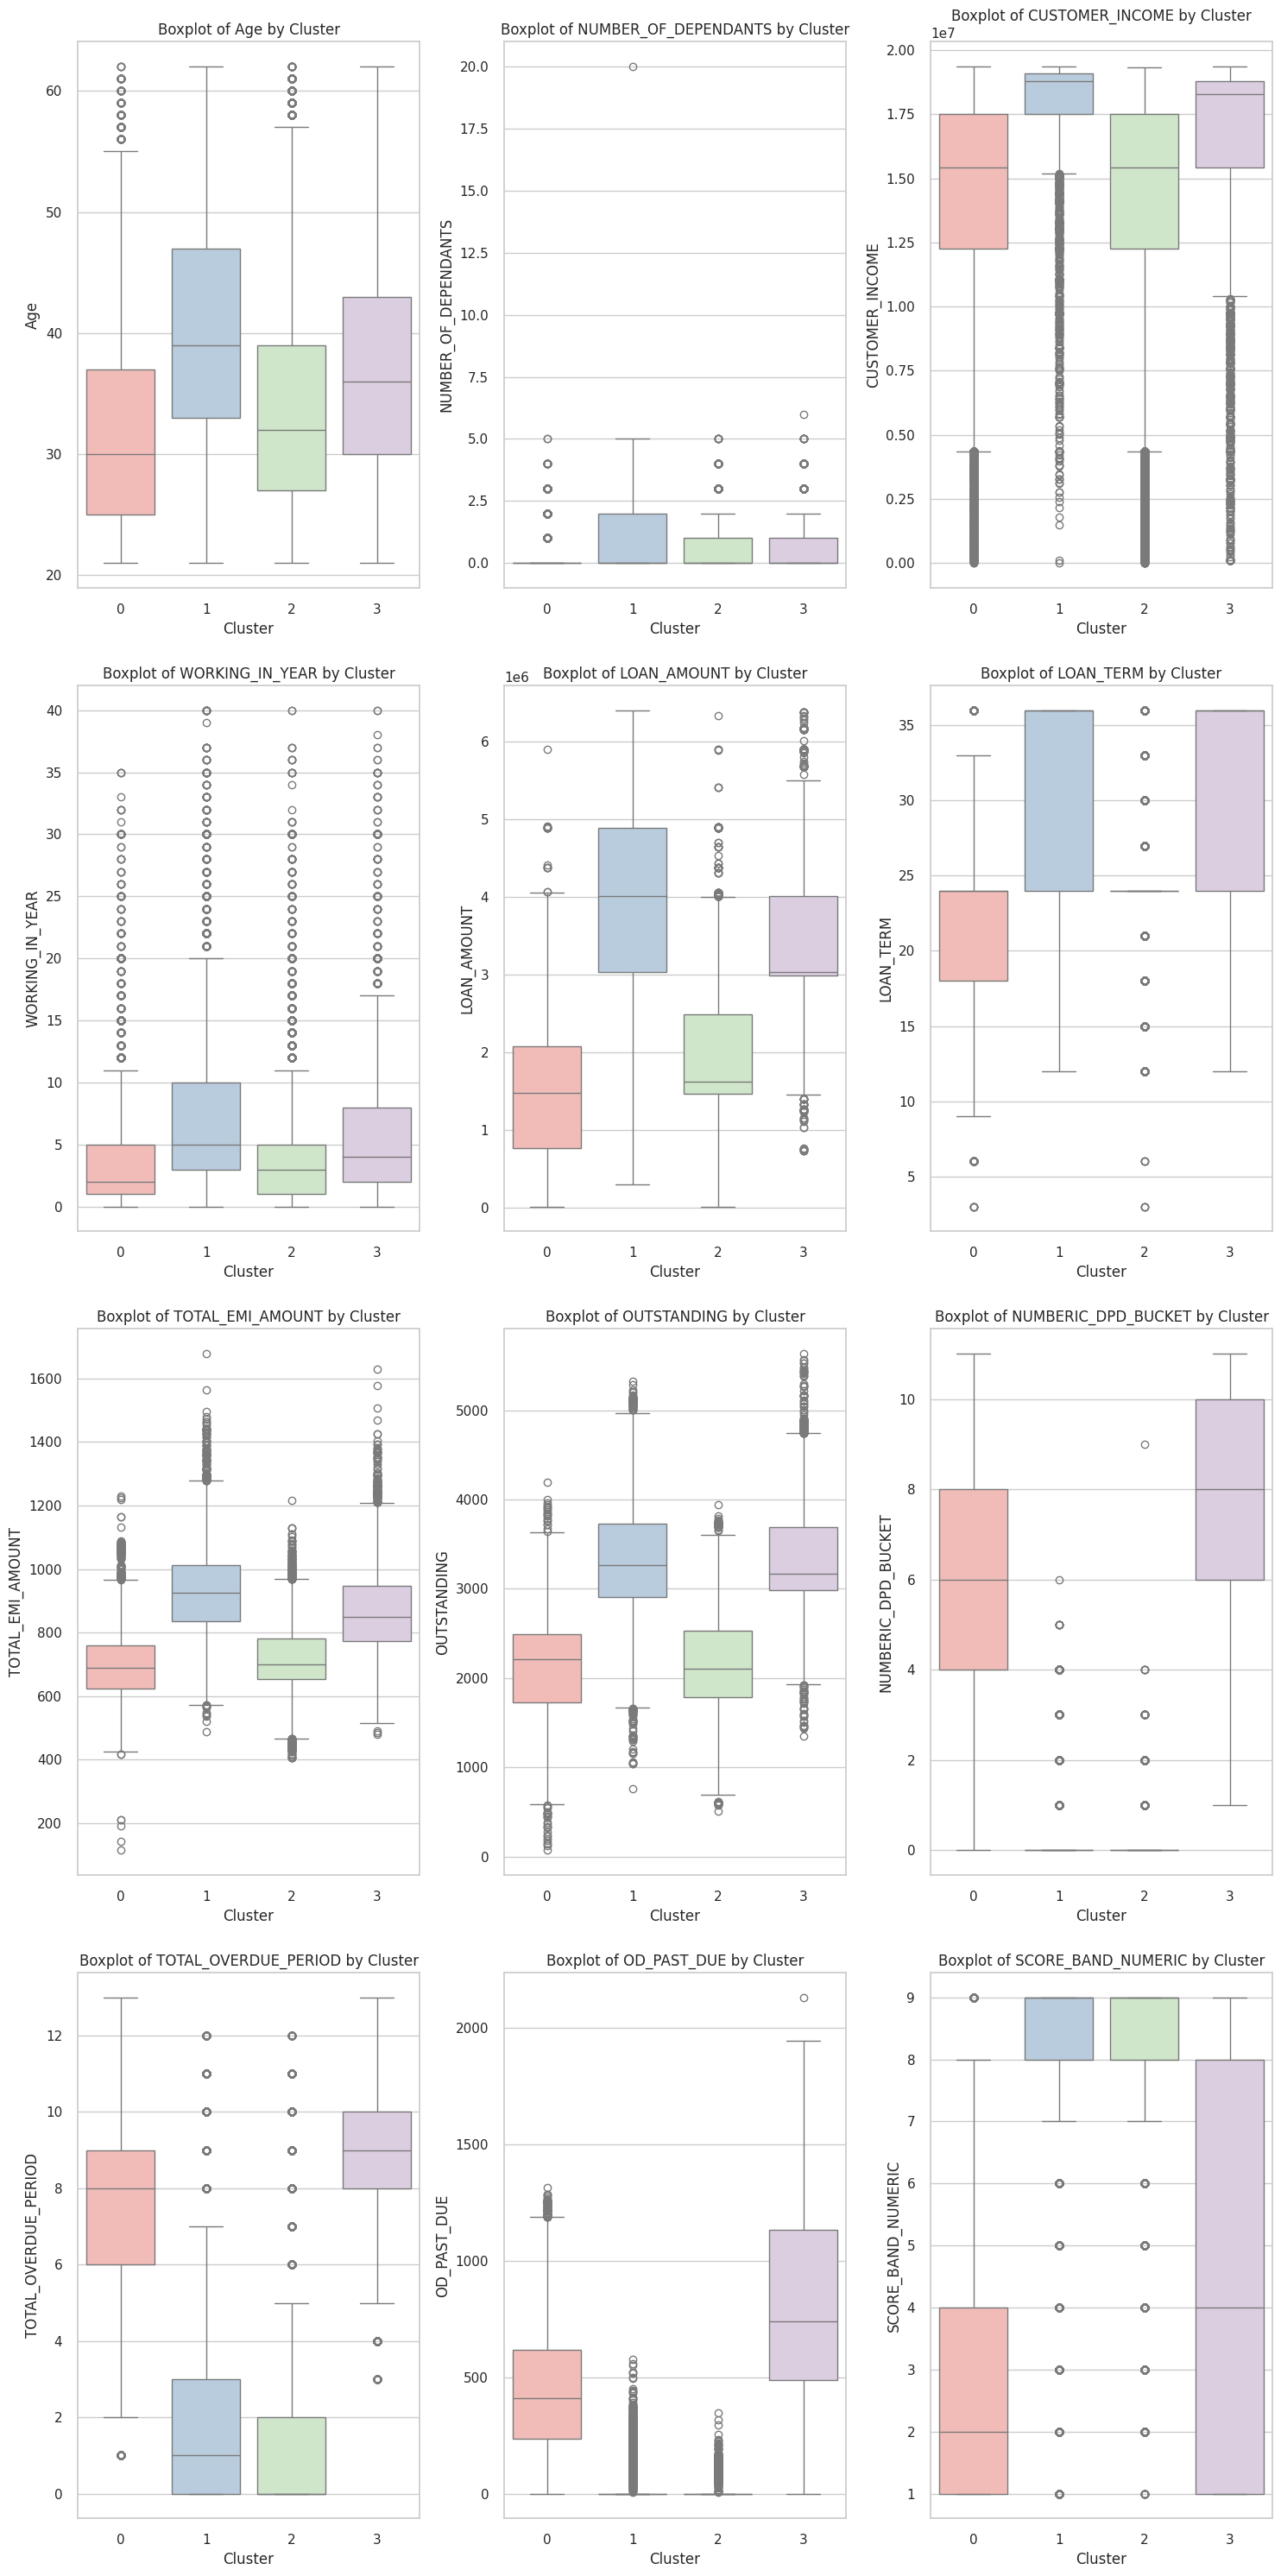

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Determine the number of features
num_features = len(features)

# Create subplots with a grid layout (you can adjust rows and columns as needed)
fig, axes = plt.subplots(nrows=(num_features // 3) + (num_features % 3 > 0), ncols=3, figsize=(15, num_features * 2.5))

# Flatten the axes array for easier iteration if there are more features than axes
axes = axes.flatten()

# Plot each feature in a subplot
for i, feature in enumerate(features):
    sns.boxplot(x='Cluster', y=feature, data=df_cluster, hue = 'Cluster', legend = False, palette="Pastel1", ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature} by Cluster')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


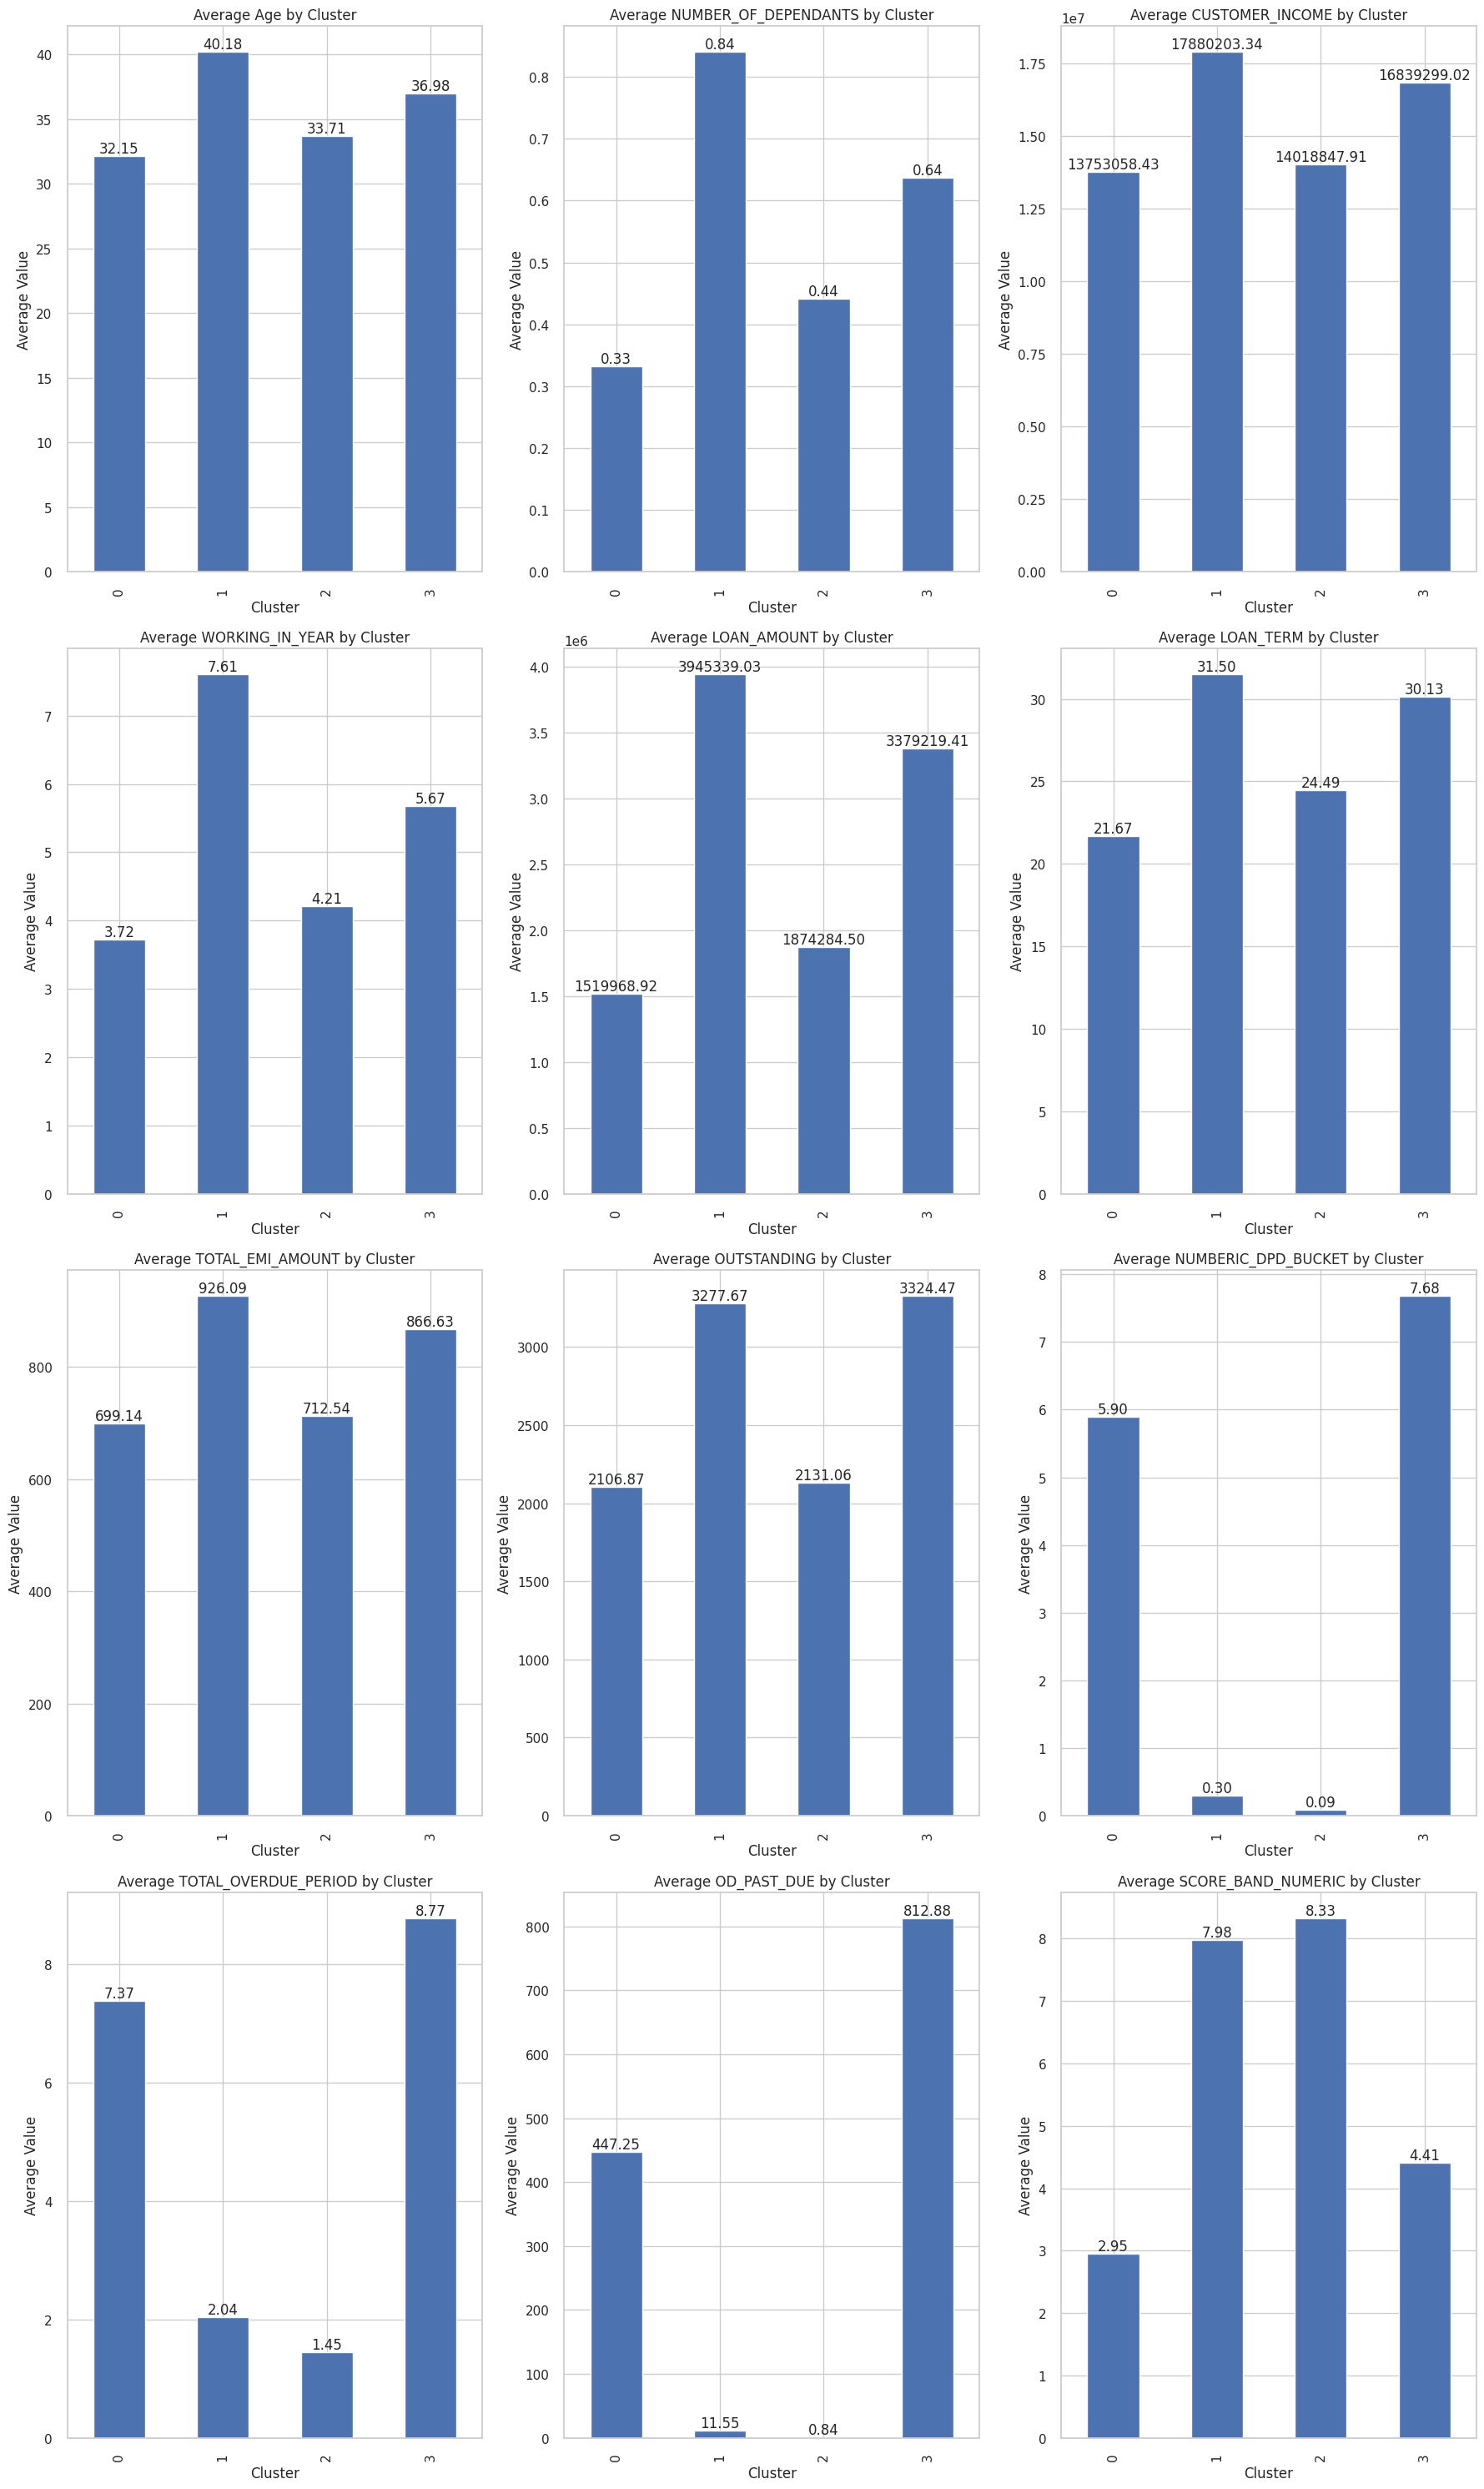

In [ ]:
import matplotlib.pyplot as plt

# Determine the number of features
num_features = len(features)

# Create subplots with a grid layout (adjust rows and columns as needed)
fig, axes = plt.subplots(nrows=(num_features // 3) + (num_features % 3 > 0), ncols=3, figsize=(18, num_features * 2.5))

# Flatten the axes array for easier iteration if there are more features than axes
axes = axes.flatten()

# Plot each feature in a subplot
for i, feature in enumerate(features):
    # Calculate the mean values by cluster
    cluster_means = df_cluster.groupby('Cluster')[feature].mean()

    # Create the bar plot on the corresponding subplot axis
    ax = cluster_means.plot(kind='bar', ax=axes[i])
    ax.set_title(f'Average {feature} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Average Value')

    # Add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')  # Format labels to 2 decimal places

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


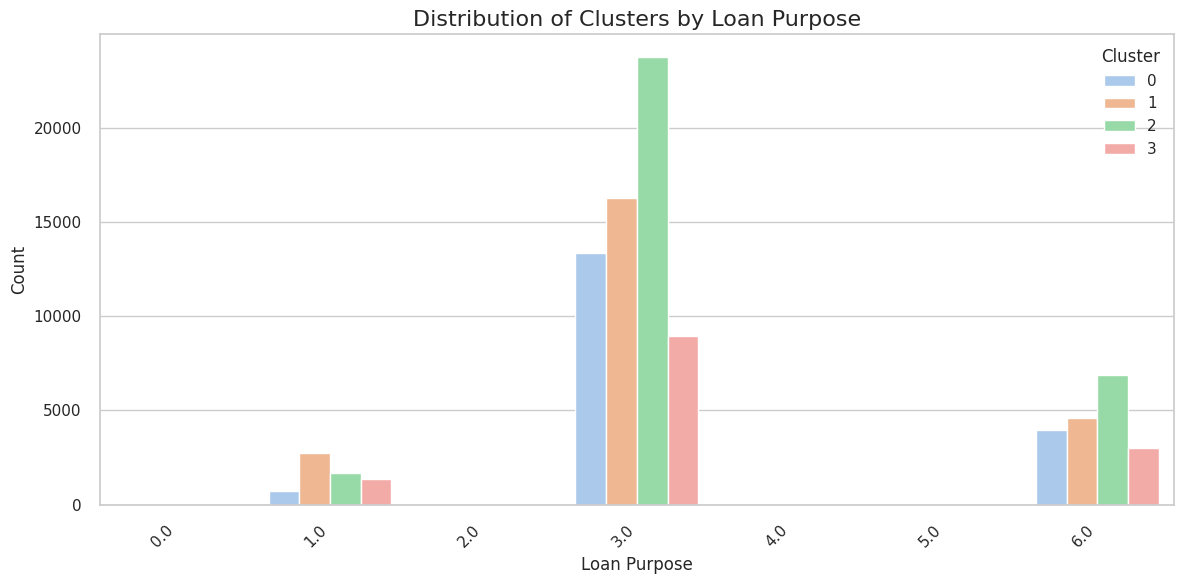

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(12, 6))

# Plot the distribution of clusters with respect to LOAN_PURPOSE
sns.countplot(data=df_cluster, x='LOAN_PURPOSE', hue='Cluster', palette='pastel')

# Customize the plot
plt.title('Distribution of Clusters by Loan Purpose', fontsize=16)
plt.xlabel('Loan Purpose', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Cluster', loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()
